<a href="https://colab.research.google.com/github/qhansen628/Predictive-Vision-Model-Experiments/blob/main/working_recursive_attention_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# get data

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

import numpy as np
# Load the MNIST dataset
(x_train, y_train), (x_val, y_val) = mnist.load_data()

# Normalize and reshape the data
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

x_train_reshaped = x_train.reshape((-1, 28, 28, 1))
x_val_reshaped = x_val.reshape((-1, 28, 28, 1))

# Convert labels to one-hot encoded format
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

# Create tf.data.Dataset for both training and validation
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_reshaped, y_train)).batch(BATCH_SIZE).shuffle(buffer_size=10000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_reshaped, y_val)).batch(BATCH_SIZE)

11490434/11490434 [==============================] - 1s 0us/step


# "RecursiveAttentionModel"

Input size: patch size

network: [hidden units, patch location probabilities, classification]


In [ ]:
import tensorflow as tf

class RecursiveAttentionModel(tf.keras.Model):
    def __init__(self, patch_size, num_hidden, max_iterations=50, temperature=1.0, time_weight=1.0, **kwargs):
        super(RecursiveAttentionModel, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.num_hidden = num_hidden
        self.num_patches = (28 // patch_size) * (28 // patch_size)
        self.max_iterations = max_iterations
        self.temperature = temperature
        self.time_weight = time_weight
        self.W = self.add_weight(shape=(self.patch_size**2 + num_hidden + self.num_patches + 10,
                                        self.patch_size**2 + num_hidden + self.num_patches + 10),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.patch_size**2 + num_hidden + self.num_patches + 10,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs, confidence_threshold=0.9):
      patches = tf.image.extract_patches(images=inputs,
                                        sizes=[1, self.patch_size, self.patch_size, 1],
                                        strides=[1, self.patch_size, self.patch_size, 1],
                                        rates=[1, 1, 1, 1],
                                        padding='VALID')
      patches_flattened = tf.reshape(patches, (-1, self.num_patches, self.patch_size**2))
      middle_patch_idx = self.num_patches // 2
      middle_patch = patches_flattened[:, middle_patch_idx, :]
      initial_S = tf.zeros((tf.shape(inputs)[0], self.num_patches))
      initial_S = tf.tensor_scatter_nd_update(initial_S, [[i, middle_patch_idx] for i in range(tf.shape(inputs)[0])], tf.ones(tf.shape(inputs)[0]))
      N = tf.concat([middle_patch,
                    tf.zeros((tf.shape(inputs)[0], self.num_hidden)),
                    initial_S,
                    tf.zeros((tf.shape(inputs)[0], 10))], axis=-1)

      predictions = []
      saccades = []

      for t in range(self.max_iterations):

          # Apply weight matrix and add bias
          N_linear = tf.matmul(N, self.W) + self.b

          # Apply activations
          P = N_linear[:, :self.patch_size**2]
          H = tf.nn.relu(N_linear[:, self.patch_size**2:self.patch_size**2 + self.num_hidden])
          S_probs = tf.nn.softmax(N_linear[:, -self.num_patches-10:-10] / self.temperature)
          Y = tf.nn.softmax(N_linear[:, -10:])

          # Stochastically select S based on probabilities
          sampled_indices = tf.random.categorical(tf.math.log(S_probs), num_samples=1)
          S_onehot = tf.one_hot(tf.squeeze(sampled_indices, axis=-1), self.num_patches)

          # Update the P segment of N using S_onehot
          P_selected = tf.reduce_sum(patches_flattened * tf.expand_dims(S_onehot, axis=-1), axis=1)

          # Concatenate to form new N
          N = tf.concat([P_selected, H, S_onehot, Y], axis=-1)

          # Append the prediction without weighting
          predictions.append(Y)
          saccades.append(S_onehot)

      return tf.stack(predictions, axis=1), tf.stack(saccades, axis=1)




In [ ]:
def train_recursive_attention_model(model, train_dataset, val_dataset, optimizer, EPOCHS=5):
    # Define loss
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    train_loss_per_step = []
    train_accuracy_per_step = []
    val_loss_results = []
    val_accuracy_results = []

    for epoch in range(EPOCHS):
        batch_accuracy = tf.keras.metrics.CategoricalAccuracy()

        # Training loop
        for x_batch, y_batch in train_dataset:
            with tf.GradientTape() as tape:
                predictions,_ = model(x_batch)


                y_batch_tiled = tf.tile(y_batch[:, tf.newaxis, :], [1, model.max_iterations, 1])
                step_losses = loss_fn(y_batch_tiled, predictions)
                step_weights = tf.range(1, model.max_iterations + 1, dtype=tf.float32) / model.max_iterations

                decay_rate = 0.2  # You can adjust this parameter
                step_weights = tf.exp(-decay_rate * tf.range(0, model.max_iterations, dtype=tf.float32))

                weighted_loss = tf.reduce_sum(step_weights * step_losses)
                loss_value = tf.reduce_mean(weighted_loss)

            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Record loss and accuracy per step
            train_loss_per_step.append(loss_value.numpy())
            batch_accuracy(y_batch, predictions[:, -1, :])
            train_accuracy_per_step.append(batch_accuracy.result().numpy())

        # Validation loop
        val_loss_avg = tf.keras.metrics.Mean()
        val_accuracy = tf.keras.metrics.CategoricalAccuracy()
        for x_val, y_val in val_dataset:
            val_predictions,_ = model(x_val)
            y_val_tiled = tf.tile(y_val[:, tf.newaxis, :], [1, model.max_iterations, 1])
            val_step_losses = loss_fn(y_val_tiled, val_predictions)
            val_weighted_loss = tf.reduce_sum(step_weights * val_step_losses)
            val_loss_value = tf.reduce_mean(val_weighted_loss)

            val_loss_avg(val_loss_value)
            val_accuracy(y_val, val_predictions[:, -1, :])

        # Calculating epoch-wise metrics
        val_loss_results.append(val_loss_avg.result())
        val_accuracy_results.append(val_accuracy.result())

        print(f"Epoch {epoch+1}: "
              f"Train Loss: {train_loss_per_step[-1]:.4f}, "
              f"Train Accuracy: {train_accuracy_per_step[-1]:.4f}, "
              f"Val Loss: {val_loss_results[-1]:.4f}, "
              f"Val Accuracy: {val_accuracy_results[-1]:.4f}")

    # Plotting the learning curves
    plt.figure(figsize=(12, 5))

    # Plot for Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_per_step, label='Train Loss')
    plt.title('Train Loss per step')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_per_step, label='Train Accuracy')
    plt.title('Train Accuracy per step')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1: Train Loss: 6.7679, Train Accuracy: 0.4361, Val Loss: 6.4514, Val Accuracy: 0.5718
Epoch 2: Train Loss: 6.2180, Train Accuracy: 0.6167, Val Loss: 5.6884, Val Accuracy: 0.6604
Epoch 3: Train Loss: 5.8811, Train Accuracy: 0.6807, Val Loss: 5.2071, Val Accuracy: 0.7107
Epoch 4: Train Loss: 5.4107, Train Accuracy: 0.7118, Val Loss: 4.9576, Val Accuracy: 0.7283
Epoch 5: Train Loss: 4.9369, Train Accuracy: 0.7391, Val Loss: 4.7401, Val Accuracy: 0.7571
Epoch 6: Train Loss: 3.8139, Train Accuracy: 0.7644, Val Loss: 4.6496, Val Accuracy: 0.7549
Epoch 7: Train Loss: 3.8716, Train Accuracy: 0.7703, Val Loss: 4.5145, Val Accuracy: 0.7640
Epoch 8: Train Loss: 4.5144, Train Accuracy: 0.7764, Val Loss: 4.3680, Val Accuracy: 0.7993
Epoch 9: Train Loss: 4.3812, Train Accuracy: 0.7890, Val Loss: 4.2960, Val Accuracy: 0.7963
Epoch 10: Train Loss: 4.0818, Train Accuracy: 0.7946, Val Loss: 4.2652, Val Accuracy: 0.7952


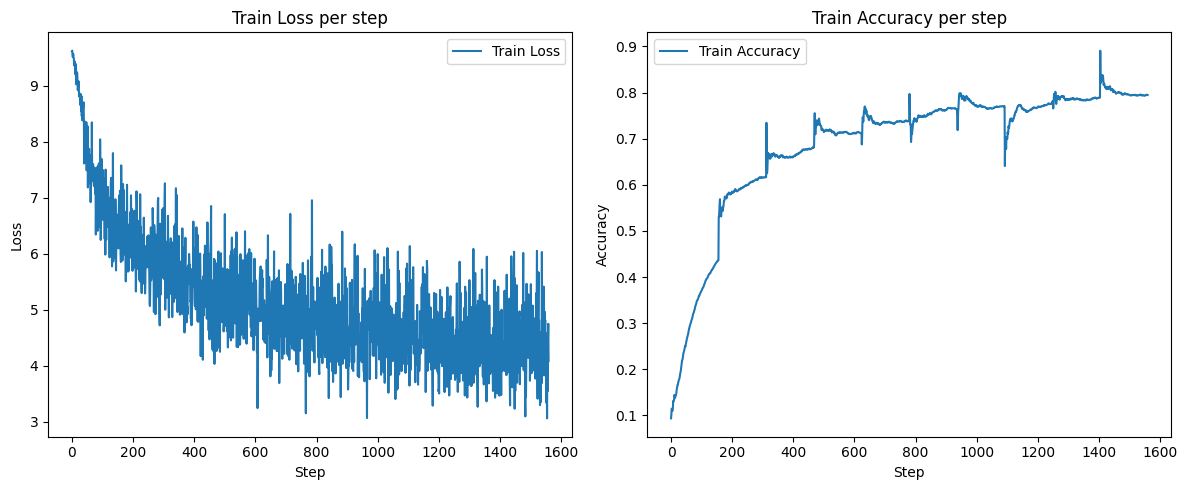

In [ ]:
import matplotlib.pyplot as plt


def train_model_with_subsample(subsample_size=None, model=None):
    # Subsample the training data if subsample_size is specified
    if subsample_size is not None:
        train_dataset_subsampled = train_dataset.take(subsample_size // BATCH_SIZE)
    else:
        train_dataset_subsampled = train_dataset

    # Initialize the optimizer and model
    optimizer = tf.keras.optimizers.Adam()
    if model == None:
      model = RecursiveAttentionModel(patch_size=10, num_hidden=100, max_iterations=5, temperature=1)

    # Train the model
    train_recursive_attention_model(model, train_dataset_subsampled, val_dataset, optimizer, EPOCHS=10)

    # Return the trained model for further inspection
    return model

# Example usage with subsample size
trained_model = train_model_with_subsample(subsample_size=10000,model = trained_model)

# Now you can inspect `trained_model` as needed


f arouund to find out: increase weighted decay to 0.2 in training:
...actually may have not run that, so its still 0.1 but training on another 10 epochs of subsample. same architecture (patch size 10x10: 100 hidden units,

Epoch 1: Train Loss: 2.7737, Train Accuracy: 0.8250, Val Loss: 3.7013, Val Accuracy: 0.8353
Epoch 2: Train Loss: 2.9372, Train Accuracy: 0.8353, Val Loss: 3.6025, Val Accuracy: 0.8505
Epoch 3: Train Loss: 4.8385, Train Accuracy: 0.8422, Val Loss: 3.5623, Val Accuracy: 0.8545
Epoch 4: Train Loss: 3.8247, Train Accuracy: 0.8565, Val Loss: 3.4842, Val Accuracy: 0.8664
Epoch 5: Train Loss: 2.5703, Train Accuracy: 0.8591, Val Loss: 3.5209, Val Accuracy: 0.8549
Epoch 6: Train Loss: 3.2502, Train Accuracy: 0.8635, Val Loss: 3.4159, Val Accuracy: 0.8736
Epoch 7: Train Loss: 4.2964, Train Accuracy: 0.8626, Val Loss: 3.4801, Val Accuracy: 0.8572
Epoch 8: Train Loss: 3.3590, Train Accuracy: 0.8729, Val Loss: 3.3853, Val Accuracy: 0.8645
Epoch 9: Train Loss: 3.6312, Train Accuracy: 0.8644, Val Loss: 3.4299, Val Accuracy: 0.8682
Epoch 10: Train Loss: 3.9371, Train Accuracy: 0.8734, Val Loss: 3.2993, Val Accuracy: 0.8818


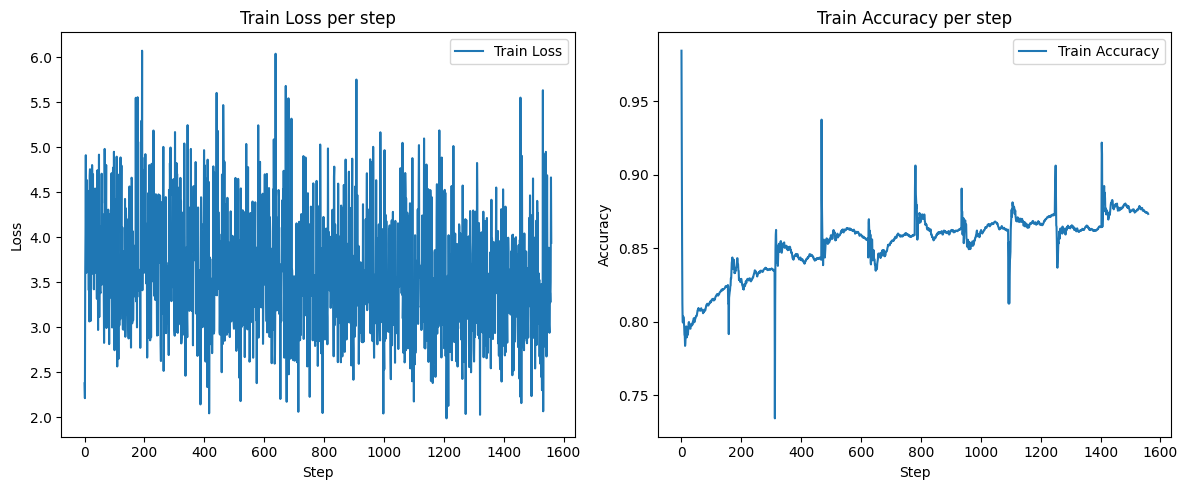

In [ ]:
# Example usage with subsample size
trained_model = train_model_with_subsample(subsample_size=10000,model = trained_model)

# Now you can inspect `trained_model` as needed

now it is set to 0.2,

Epoch 1: Train Loss: 2.8641, Train Accuracy: 0.8815, Val Loss: 3.3404, Val Accuracy: 0.8740
Epoch 2: Train Loss: 2.6388, Train Accuracy: 0.8785, Val Loss: 3.3370, Val Accuracy: 0.8744
Epoch 3: Train Loss: 3.0528, Train Accuracy: 0.8809, Val Loss: 3.3249, Val Accuracy: 0.8751
Epoch 4: Train Loss: 3.7419, Train Accuracy: 0.8756, Val Loss: 3.2218, Val Accuracy: 0.8872
Epoch 5: Train Loss: 4.2738, Train Accuracy: 0.8846, Val Loss: 3.2524, Val Accuracy: 0.8836
Epoch 6: Train Loss: 3.1186, Train Accuracy: 0.8821, Val Loss: 3.2025, Val Accuracy: 0.8887
Epoch 7: Train Loss: 4.5184, Train Accuracy: 0.8789, Val Loss: 3.2314, Val Accuracy: 0.8840
Epoch 8: Train Loss: 3.0859, Train Accuracy: 0.8899, Val Loss: 3.2224, Val Accuracy: 0.8792
Epoch 9: Train Loss: 3.4271, Train Accuracy: 0.8971, Val Loss: 3.1657, Val Accuracy: 0.8889
Epoch 10: Train Loss: 3.9430, Train Accuracy: 0.8946, Val Loss: 3.1552, Val Accuracy: 0.8911


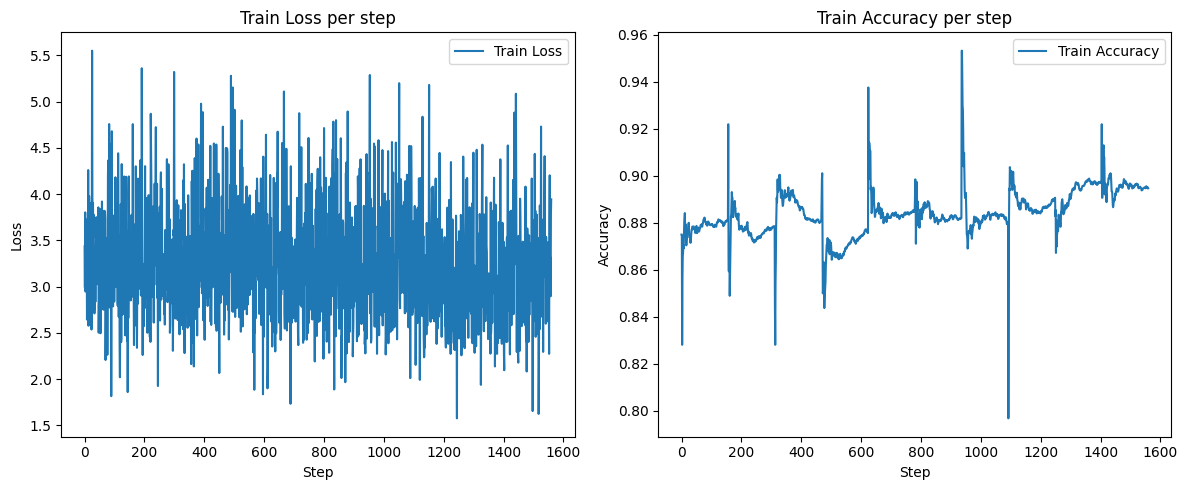

In [ ]:
# Example usage with subsample size
trained_model = train_model_with_subsample(subsample_size=10000,model = trained_model)

# Now you can inspect `trained_model` as needed

# OG inspect

(64, 8) (64, 8, 4) (64, 8, 10)


<ipython-input-21-ffcdb73ec73b>:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b:" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x, y, 'b:', color='blue', marker=(3, 0, np.degrees(np.arctan2(np.diff(y), np.diff(x))[0])))  # Blue dotted line with arrow


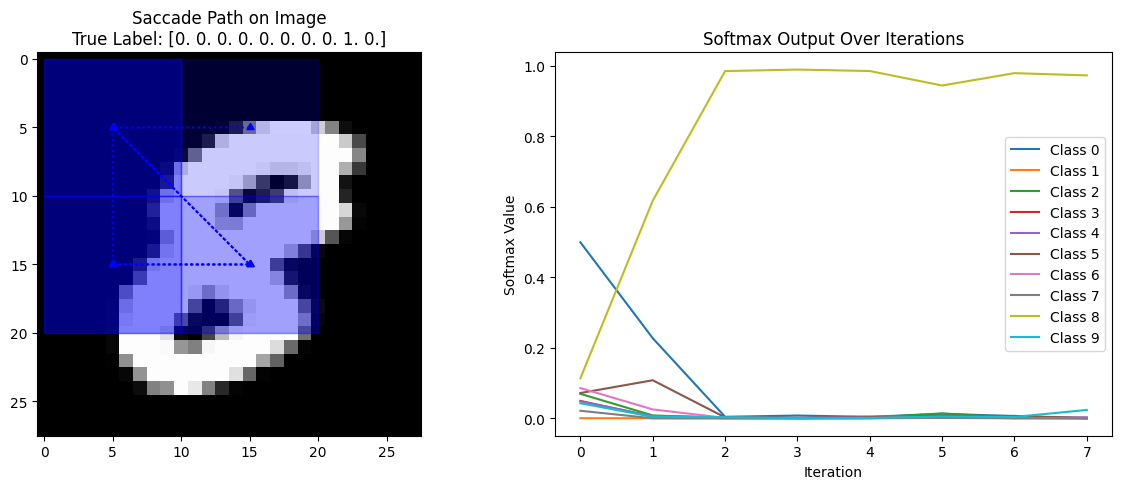

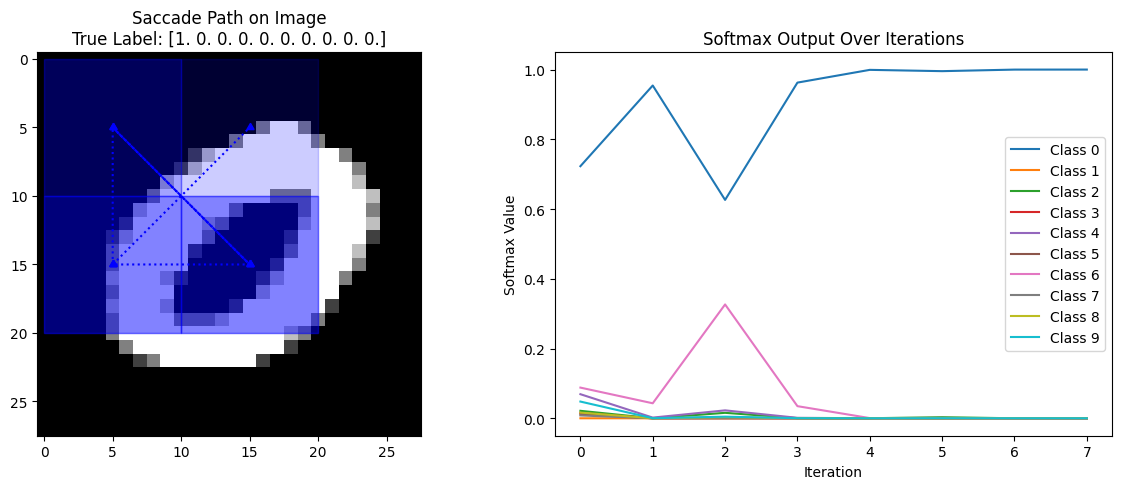

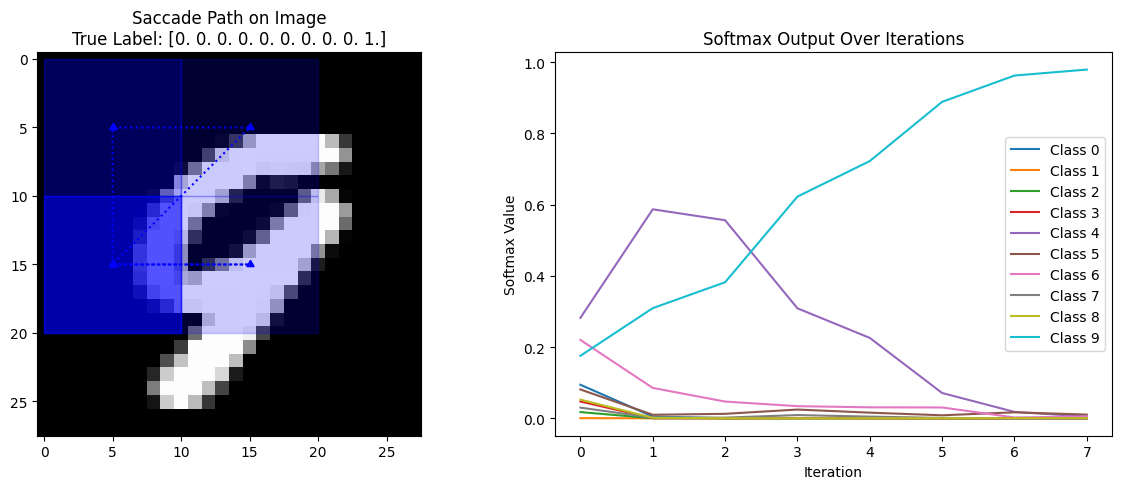

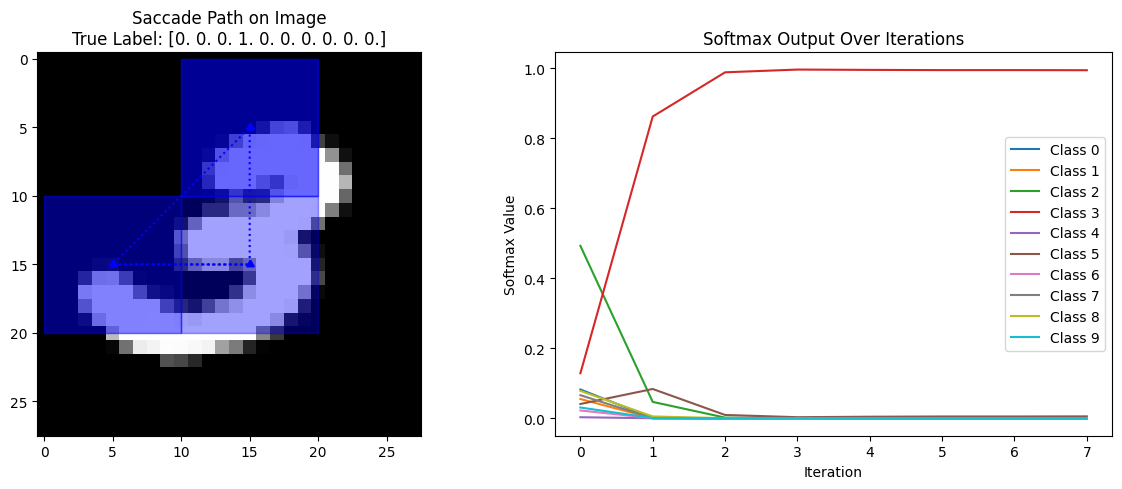

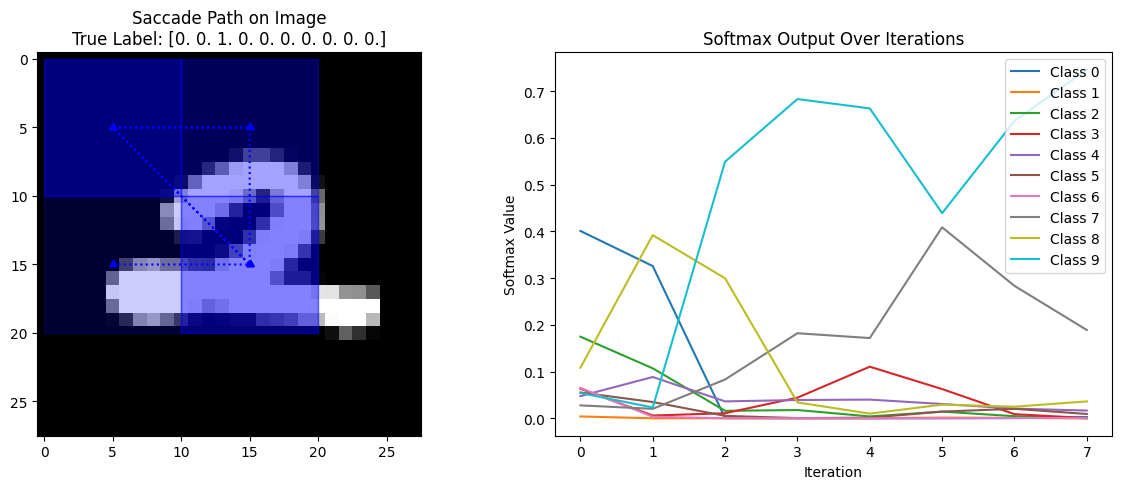

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def inspect_model(model, train_data, num_steps=None, num_plots=1):
    # If num_steps is not provided, use model's max_iterations
    if num_steps is None:
        num_steps = model.max_iterations
    else:
        model.max_iterations = num_steps

    # Randomly select an image from the training data
    img, label = next(iter(train_data.shuffle(1000).take(1)))
    img = np.squeeze(img.numpy())

    # Reshape img to ensure it has 4 dimensions
    img_reshaped = tf.reshape(img, (-1, 28, 28, 1))

    # Get the model predictions
    predictions,saccades = model(img_reshaped)

    # Extract saccade positions
    saccades = saccades.numpy()
    saccade_positions = np.argmax(saccades, axis=2)
    print(saccade_positions.shape,saccades.shape,predictions.shape)
    for plot_idx in range(num_plots):
        # Calculate the center of the selected patch
        patch_centers = [(i // (28 // model.patch_size) * model.patch_size + model.patch_size // 2,
                          i % (28 // model.patch_size) * model.patch_size + model.patch_size // 2)
                         for i in saccade_positions[plot_idx]]

        # Add the initial middle patch to the path
        middle_patch_idx = model.num_patches // 2
        middle_patch_center = (middle_patch_idx // (28 // model.patch_size) * model.patch_size + model.patch_size // 2,
                               middle_patch_idx % (28 // model.patch_size) * model.patch_size + model.patch_size // 2)
        patch_centers.insert(0, middle_patch_center)

        # Plotting
        plt.figure(figsize=(12, 5))

        # Left plot: Image with saccade path
        plt.subplot(1, 2, 1)
        plt.imshow(np.squeeze(img_reshaped[plot_idx]), cmap='gray')

        # Draw saccade path with translucent shaded box and arrow
        if patch_centers:
            y, x = zip(*patch_centers)
            plt.plot(x, y, 'b:', color='blue', marker=(3, 0, np.degrees(np.arctan2(np.diff(y), np.diff(x))[0])))  # Blue dotted line with arrow
            for (cy, cx) in patch_centers:
                rect = patches.Rectangle((cx - model.patch_size // 2, cy - model.patch_size // 2), model.patch_size, model.patch_size,
                                         linewidth=1, edgecolor='blue', facecolor='blue', alpha=0.2)
                plt.gca().add_patch(rect)

        plt.title(f"Saccade Path on Image\nTrue Label: {label.numpy()[plot_idx]}")

        # Right plot: Softmax outputs
        plt.subplot(1, 2, 2)
        softmax_vals = predictions.numpy()
        for i in range(10):
            plt.plot(softmax_vals[plot_idx, :, i], label=f"Class {i}")

        plt.title("Softmax Output Over Iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Softmax Value")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Inspect the model for a specific number of steps

inspect_model(trained_model, val_dataset, num_steps=8,num_plots=5)


In [ ]:
trained_model.summary()
model=trained_model
def analyze_recursive_attention_model(patch_size, num_hidden, max_iterations=50, temperature=1.0, time_weight=1.0):
    """
    Analyzes the RecursiveAttentionModel by calculating and printing its total number of parameters and estimated FLOPs.

    Args:
    - patch_size (int): Size of the image patch.
    - num_hidden (int): Number of hidden neurons.
    - max_iterations (int): Maximum number of iterations for recursion.
    - temperature (float): Temperature parameter for softmax.
    - time_weight (float): Weight parameter for time.

    Returns:
    - None
    """
    # Instantiate the model
    model = RecursiveAttentionModel(patch_size, num_hidden, max_iterations, temperature, time_weight)

    # Calculate the number of parameters
    num_params_W = model.W.shape[0] * model.W.shape[1]
    num_params_b = model.b.shape[0]
    total_params = num_params_W + num_params_b

    print(f"Total Parameters: {total_params}")

    # Estimate FLOPs
    # For simplicity, we focus on the matrix multiplication within each iteration, not including softmax and other operations
    flops_per_iteration = 2 * (model.W.shape[0] * model.W.shape[1])  # 2 * (input_dim * output_dim)
    total_flops = flops_per_iteration * max_iterations

    print(f"Estimated FLOPs for forward pass: {total_flops}")

analyze_recursive_attention_model(model.patch_size, model.num_hidden, model.max_iterations)

Model: "recursive_attention_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 68906 (269.16 KB)
Trainable params: 68906 (269.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Total Parameters: 68906
Estimated FLOPs for forward pass: 1372880


# Early Stopping RAN

In [ ]:
import tensorflow as tf

class RecursiveAttentionModel_2(tf.keras.Model):
    def __init__(self, patch_size, num_hidden, max_iterations=50, temperature=1.0, time_weight=1.0, **kwargs):
        super(RecursiveAttentionModel_2, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.num_hidden = num_hidden
        self.num_patches = (28 // patch_size) * (28 // patch_size)
        self.max_iterations = max_iterations
        self.temperature = temperature
        self.time_weight = time_weight
        self.W = self.add_weight(shape=(self.patch_size**2 + num_hidden + self.num_patches + 10,
                                        self.patch_size**2 + num_hidden + self.num_patches + 10),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.patch_size**2 + num_hidden + self.num_patches + 10,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs, confidence_threshold=0.9):
        patches = tf.image.extract_patches(images=inputs,
                                           sizes=[1, self.patch_size, self.patch_size, 1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        patches_flattened = tf.reshape(patches, (-1, self.num_patches, self.patch_size**2))
        middle_patch_idx = self.num_patches // 2
        middle_patch = patches_flattened[:, middle_patch_idx, :]
        initial_S = tf.zeros((tf.shape(inputs)[0], self.num_patches))
        initial_S = tf.tensor_scatter_nd_update(initial_S, [[i, middle_patch_idx] for i in range(tf.shape(inputs)[0])], tf.ones(tf.shape(inputs)[0]))
        N = tf.concat([middle_patch,
                       tf.zeros((tf.shape(inputs)[0], self.num_hidden)),
                       initial_S,
                       tf.zeros((tf.shape(inputs)[0], 10))], axis=-1)

        all_predictions = []
        all_saccades = []

        for t in range(self.max_iterations):
            N_linear = tf.matmul(N, self.W) + self.b
            P = N_linear[:, :self.patch_size**2]
            H = tf.nn.relu(N_linear[:, self.patch_size**2:self.patch_size**2 + self.num_hidden])
            S_probs = tf.nn.softmax(N_linear[:, -self.num_patches-10:-10] / self.temperature)
            Y = tf.nn.softmax(N_linear[:, -10:])

            all_predictions.append(Y)
            saccades = tf.one_hot(tf.squeeze(tf.random.categorical(tf.math.log(S_probs), num_samples=1), axis=-1), self.num_patches)
            all_saccades.append(saccades)

            # Update N for the next iteration
            P_selected = tf.reduce_sum(patches_flattened * tf.expand_dims(saccades, axis=-1), axis=1)
            N = tf.concat([P_selected, H, saccades, Y], axis=-1)

        # Stack along the new axis to create a tensor of shape (batch_size, max_iterations, num_classes)
        predictions = tf.stack(all_predictions, axis=1)
        saccades = tf.stack(all_saccades, axis=1)

        # Now, you have predictions for each iteration and can apply the logic to select final predictions
        # based on the confidence threshold for each instance outside this model
        return predictions, saccades


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def train_recursive_attention_model_2(model, train_dataset, val_dataset, optimizer, EPOCHS=5, confidence_threshold=0.9):
    # Define loss
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    train_loss_results = []
    train_accuracy_results = []
    val_loss_results = []
    val_accuracy_results = []

    for epoch in range(EPOCHS):
        train_loss_avg = tf.keras.metrics.Mean()
        train_accuracy = tf.keras.metrics.CategoricalAccuracy()
        val_loss_avg = tf.keras.metrics.Mean()
        val_accuracy = tf.keras.metrics.CategoricalAccuracy()

        # Training loop
        for x_batch, y_batch in train_dataset:
            with tf.GradientTape() as tape:
                predictions, _ = model(x_batch)
                final_predictions = select_final_predictions(predictions, confidence_threshold)

                y_batch_tiled = tf.tile(y_batch[:, tf.newaxis, :], [1, model.max_iterations, 1])
                step_losses = loss_fn(y_batch_tiled, predictions)
                step_weights = tf.range(1, model.max_iterations + 1, dtype=tf.float32) / model.max_iterations

                decay_rate = 0.1  # You can adjust this parameter
                step_weights = tf.exp(-decay_rate * tf.range(0, model.max_iterations, dtype=tf.float32))

                weighted_loss = tf.reduce_sum(step_weights * step_losses)
                loss_value = tf.reduce_mean(weighted_loss)


            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            train_loss_avg(loss_value)
            train_accuracy(y_batch, final_predictions)

        # Validation loop
        for x_val, y_val in val_dataset:
            val_predictions, _ = model(x_val)
            final_val_predictions = select_final_predictions(val_predictions, confidence_threshold)


            y_val_tiled = tf.tile(y_val[:, tf.newaxis, :], [1, model.max_iterations, 1])
            val_step_losses = loss_fn(y_val_tiled, final_val_predictions)
            val_weighted_loss = tf.reduce_sum(step_weights * val_step_losses)
            val_loss_value = tf.reduce_mean(val_weighted_loss)

            val_loss_avg(val_loss_value)
            val_accuracy(y_val, final_val_predictions[:, -1, :])

        # Calculating epoch-wise metrics
        train_loss_results.append(train_loss_avg.result())
        train_accuracy_results.append(train_accuracy.result())
        val_loss_results.append(val_loss_avg.result())
        val_accuracy_results.append(val_accuracy.result())

        print(f"Epoch {epoch+1}: "
              f"Train Loss: {train_loss_avg.result():.4f}, "
              f"Train Accuracy: {train_accuracy.result():.4f}, "
              f"Val Loss: {val_loss_avg.result():.4f}, "
              f"Val Accuracy: {val_accuracy.result():.4f}")

    # Plotting the learning curves
    plt.figure(figsize=(12, 5))

    # Plot for Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), train_loss_results, label='Train Loss')
    plt.plot(range(EPOCHS), val_loss_results, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(EPOCHS), train_accuracy_results, label='Train Accuracy')
    plt.plot(range(EPOCHS), val_accuracy_results, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()




def select_final_predictions(predictions, threshold=0.9):
    # predictions shape: (batch_size, max_iterations, num_classes)
    confidences = tf.reduce_max(predictions, axis=-1)  # Max confidence for each class (batch_size, max_iterations)
    exceeded_threshold = confidences > threshold  # Where confidence exceeds threshold (batch_size, max_iterations)

    # Determine the first iteration where confidence exceeds the threshold for each instance
    first_exceeds_threshold = tf.argmax(exceeded_threshold, axis=-1, output_type=tf.int32)

    # Check cases where the threshold is never exceeded (no True values in exceeded_threshold)
    never_exceeds = ~tf.reduce_any(exceeded_threshold, axis=-1)

    # Create a tensor filled with the index of the last iteration for each instance in the batch
    last_iteration = tf.fill(dims=tf.shape(first_exceeds_threshold), value=predictions.shape[1] - 1)

    # Use tf.where to select the correct iteration index for each instance
    # This operation selects `last_iteration` indices where `never_exceeds` is True, and `first_exceeds_threshold` otherwise
    selected_iterations = tf.where(never_exceeds, last_iteration, first_exceeds_threshold)

    # Gather the selected predictions for each instance
    batch_indices = tf.range(tf.shape(predictions)[0], dtype=tf.int32)
    selected_indices = tf.stack([batch_indices, selected_iterations], axis=1)
    final_predictions = tf.gather_nd(predictions, selected_indices)

    return final_predictions






In [ ]:
import matplotlib.pyplot as plt


def train_model_with_subsample_2(subsample_size=None, model=None):
    # Subsample the training data if subsample_size is specified
    if subsample_size is not None:
        train_dataset_subsampled = train_dataset.take(subsample_size // BATCH_SIZE)
    else:
        train_dataset_subsampled = train_dataset

    # Initialize the optimizer and model
    optimizer = tf.keras.optimizers.Adam()
    if model == None:
      model = RecursiveAttentionModel_2(patch_size=6, num_hidden=200, max_iterations=20, temperature=1)

    # Train the model
    train_recursive_attention_model_2(model, train_dataset_subsampled, val_dataset, optimizer, EPOCHS=4)

    # Return the trained model for further inspection
    return model

# Example usage with subsample size
trained_model_2 = train_model_with_subsample_2(subsample_size=10000)

# Now you can inspect `trained_model` as needed


ValueError: Shapes (64, 20, 10) and (64, 10) are incompatible

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

def select_final_iteration(predictions, confidence_threshold=0.9):
    # Assuming predictions shape is (num_samples, max_iterations, num_classes)
    max_confidences = tf.reduce_max(predictions, axis=-1)  # Shape: (num_samples, max_iterations)
    exceeds_threshold = max_confidences > confidence_threshold
    final_iterations = tf.argmax(exceeds_threshold, axis=-1)  # Shape: (num_samples,)
    # If confidence never exceeds threshold, use the last iteration
    final_iterations = tf.where(tf.reduce_any(exceeds_threshold, axis=-1), final_iterations, predictions.shape[1] - 1)
    return final_iterations.numpy()

def inspect_model_2(model, train_data, confidence_threshold=0.9, num_plots=4):
    # Randomly select an image from the training data
    img, label = next(iter(train_data.shuffle(1000).take(1)))
    img = img.numpy()  # Ensure img is a NumPy array

    # Get the model predictions
    predictions, saccades = model(tf.convert_to_tensor(img))
    print(predictions.shape)
    # Determine the final iteration for each instance based on the confidence threshold
    final_iterations = select_final_iteration(predictions, confidence_threshold)

    for plot_idx in range(num_plots):
        final_iteration = final_iterations[plot_idx]

        # Only consider saccades and predictions up to the final iteration
        relevant_saccades = saccades[plot_idx, :final_iteration+1, :]
        relevant_predictions = predictions[plot_idx, :final_iteration+1, :]

        # Extract saccade positions
        saccade_positions = np.argmax(relevant_saccades.numpy(), axis=1)

        # Calculate the center of the selected patch
        patch_centers = [(i // (28 // model.patch_size) * model.patch_size + model.patch_size // 2,
                          i % (28 // model.patch_size) * model.patch_size + model.patch_size // 2)
                         for i in saccade_positions]

        # Plotting
        plt.figure(figsize=(12, 5))

        # Left plot: Image with saccade path
        plt.subplot(1, 2, 1)
        plt.imshow(np.squeeze(img[plot_idx]), cmap='gray')
        if len(patch_centers) > 0:
            y, x = zip(*patch_centers)
            plt.plot(x, y, 'b:', color='blue')  # Blue dotted line
            for (cy, cx) in patch_centers:
                rect = patches.Rectangle((cx - model.patch_size // 2, cy - model.patch_size // 2), model.patch_size, model.patch_size,
                                         linewidth=1, edgecolor='blue', facecolor='blue', alpha=0.2)
                plt.gca().add_patch(rect)

        plt.title(f"Saccade Path on Image\nTrue Label: {label.numpy()[plot_idx]}")

        # Right plot: Softmax outputs
        plt.subplot(1, 2, 2)
        for i in range(10):
            plt.plot(relevant_predictions.numpy()[:, i], label=f"Class {i}")

        plt.title("Softmax Output Over Iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Softmax Value")
        plt.legend()

        plt.tight_layout()
        plt.show()
inspect_model_2(trained_model_2,val_dataset)
print(trained_model_2.max_iterations)

NameError: name 'trained_model_2' is not defined

# Build and train standard FF ANN

In [ ]:
import tensorflow as tf

def build_and_analyze_ffnn(layer_neurons):
    """
    Builds a feedforward neural network based on the specified architecture and analyzes its complexity.

    Args:
    - layer_neurons (list of int): Number of neurons in each hidden layer.

    Returns:
    - model: The constructed Keras model.
    """
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))  # Flatten the input image

    # Add hidden layers as specified by layer_neurons
    for neurons in layer_neurons:
        model.add(tf.keras.layers.Dense(neurons, activation='relu'))

    # Output layer for classification of 10 classes
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    # Compile the model (required to build the model and calculate params)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Print the summary to get the parameter count
    model.summary()

    # Calculate and print FLOPs
    total_flops = calculate_flops(model)
    print(f"Estimated FLOPs for forward pass: {total_flops}")

    return model

def calculate_flops(model):
    """
    Calculate the FLOPs for the given model. This is a simplified calculation that assumes
    FLOPs are dominated by matrix multiplications in Dense layers.

    Args:
    - model: The Keras model to analyze.

    Returns:
    - int: The estimated number of floating-point operations (FLOPs).
    """
    total_flops = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            # FLOPs for a Dense layer: 2 * input_units * output_units
            input_shape = layer.input_shape
            output_shape = layer.output_shape
            flops_per_instance = 2 * input_shape[-1] * output_shape[-1]
            total_flops += flops_per_instance

    return total_flops

# Example usage
layer_neurons = [128, 64]  # Example architecture
build_and_analyze_ffnn(layer_neurons)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               100480    
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Estimated FLOPs for forward pass: 218368


In [ ]:
import matplotlib.pyplot as plt

def train_and_plot(model, train_dataset, val_dataset, epochs=5, batch_size=32, subsample_size=None):
    """
    Trains an already-initialized feedforward neural network on a given dataset and plots the learning and accuracy curves.

    Args:
    - model: An initialized TensorFlow/Keras model.
    - train_dataset: A tf.data.Dataset object for training.
    - val_dataset: A tf.data.Dataset object for validation.
    - epochs (int): Number of epochs to train for.
    - batch_size (int): Batch size for training.
    - subsample_size (int, optional): Size of the subsample to train on. If None, uses the full dataset.
    """

    # Subsample the training data if subsample_size is specified
    if subsample_size is not None:
        train_dataset = train_dataset.take(subsample_size // batch_size)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, batch_size=batch_size)

    # Plotting
    plt.figure(figsize=(14, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()

# Assume the MNIST dataset is loaded and prepared in variables `train_dataset` and `val_dataset`
# Example model initialization (you can replace this with your actual function call)
model = build_and_analyze_ffnn([128, 64])  # Assuming this function returns a compiled model

# Now use the new function to train and plot
train_and_plot(model, train_dataset, val_dataset, epochs=5, batch_size=64, subsample_size=10000)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               100480    
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Estimated FLOPs for forward pass: 218368
Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-28-58748967a727>", line 56, in <cell line: 56>

  File "<ipython-input-28-58748967a727>", line 26, in train_and_plot

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [64,10] and labels shape [640]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_5324747]

# Predictive encoding


In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1
class PredictiveRecursiveAttentionModel(tf.keras.Model):
    def __init__(self, patch_size, num_hidden, max_iterations=50, temperature=1.0, time_weight=1.0, l1_reg=0.01, **kwargs):
        super(PredictiveRecursiveAttentionModel, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.num_hidden = num_hidden
        self.num_patches = (28 // patch_size) * (28 // patch_size)
        self.max_iterations = max_iterations
        self.temperature = temperature
        self.time_weight = time_weight
        self.W = self.add_weight(shape=(self.patch_size**2 + num_hidden + self.num_patches + 10,
                                        self.patch_size**2 + num_hidden + self.num_patches + 10),
                                 initializer='random_normal',
                                 trainable=True,
                                 regularizer=l1(l1_reg))  # Added L1 regularization here
        self.b = self.add_weight(shape=(self.patch_size**2 + num_hidden + self.num_patches + 10,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        patches = tf.image.extract_patches(images=inputs,
                                           sizes=[1, self.patch_size, self.patch_size, 1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        patches_flattened = tf.reshape(patches, (-1, self.num_patches, self.patch_size**2))
        middle_patch_idx = self.num_patches // 2
        middle_patch = patches_flattened[:, middle_patch_idx, :]
        initial_S = tf.zeros((tf.shape(inputs)[0], self.num_patches))
        initial_S = tf.tensor_scatter_nd_update(initial_S, [[i, middle_patch_idx] for i in range(tf.shape(inputs)[0])], tf.ones(tf.shape(inputs)[0]))
        N = tf.concat([middle_patch,
                       tf.zeros((tf.shape(inputs)[0], self.num_hidden)),
                       initial_S,
                       tf.zeros((tf.shape(inputs)[0], 10))], axis=-1)

        predictions = []
        P_pred = middle_patch

        for t in range(self.max_iterations):
            # Apply weight matrix and add bias
            N_linear = tf.matmul(N, self.W) + self.b

            # Apply activations
            P = N_linear[:, :self.patch_size**2]  # This is P_pred for the next iteration
            H = tf.nn.relu(N_linear[:, self.patch_size**2:self.patch_size**2 + self.num_hidden])
            S_probs = tf.nn.softmax(N_linear[:, -self.num_patches-10:-10] / self.temperature)
            Y = tf.nn.softmax(N_linear[:, -10:])

            # Stochastically select S based on probabilities
            sampled_indices = tf.random.categorical(tf.math.log(S_probs), num_samples=1)
            S_onehot = tf.one_hot(tf.squeeze(sampled_indices, axis=-1), self.num_patches)

            # Update the P segment of N using the difference between P_selected and P_pred
            P_selected = tf.reduce_sum(patches_flattened * tf.expand_dims(S_onehot, axis=-1), axis=1)
            P_diff = P_selected - P_pred

            # Concatenate to form new N
            N = tf.concat([P_diff, H, S_onehot, Y], axis=-1)

            # Update P_pred for the next iteration
            P_pred = P

            # Append the prediction
            predictions.append(Y)

        return tf.stack(predictions, axis=1)


In [ ]:
0

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.regularizers import l1

class PredictiveRecursiveAttentionModel(tf.keras.Model):
    def __init__(self, patch_size, num_hidden, max_iterations=50, temperature=1.0, time_weight=1.0, l1_reg=0.05, **kwargs):
        super(PredictiveRecursiveAttentionModel, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.num_hidden = num_hidden
        self.num_patches = (28 // patch_size) * (28 // patch_size)
        self.max_iterations = max_iterations
        self.temperature = temperature
        self.time_weight = time_weight
        self.W = self.add_weight(shape=(self.patch_size**2 + num_hidden + 2 + 10,
                                        self.patch_size**2 + num_hidden + 2 + 10),
                                 initializer='random_normal',
                                 trainable=True,
                                 regularizer=l1(l1_reg))
        self.b = self.add_weight(shape=(self.patch_size**2 + num_hidden + 2 + 10,),
                                 initializer='zeros',
                                 trainable=True)
# Create mask for W and b
        self.W_mask = self.create_W_mask()
        self.b_mask = self.create_b_mask()

    def create_W_mask(self):
        # Initialize mask for W with ones
        W_mask = np.ones((self.patch_size**2 + self.num_hidden + 2 + 10,
                          self.patch_size**2 + self.num_hidden + 2 + 10))

        # Set diagonal to 0
        np.fill_diagonal(W_mask, 0)

        # Mask out P to P and Y to Y connections
        P_range = range(self.patch_size**2)
        Y_range = range(self.patch_size**2 + self.num_hidden + 2, self.patch_size**2 + self.num_hidden + 2 + 10)
        W_mask[P_range, P_range] = 0
        W_mask[Y_range, Y_range] = 0

        return W_mask
    def create_b_mask(self):
          # Initialize mask for b with ones
          b_mask = np.ones((self.patch_size**2 + self.num_hidden + 2 + 10,))

          # Mask out biases for S neurons
          S_range = range(self.patch_size**2 + self.num_hidden, self.patch_size**2 + self.num_hidden + 2)
          b_mask[S_range] = 0

          return b_mask
    def coordinates_to_patch_index(self, x_coords, y_coords, img_size):
        x_indices = tf.cast(tf.round(x_coords * (img_size - 1)), dtype=tf.int32)
        y_indices = tf.cast(tf.round(y_coords * (img_size - 1)), dtype=tf.int32)
        patch_indices = (y_indices // self.patch_size) * (img_size // self.patch_size) + (x_indices // self.patch_size)
        return patch_indices

    def call(self, inputs, training=True):
        patches = tf.image.extract_patches(images=inputs,
                                           sizes=[1, self.patch_size, self.patch_size, 1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        patches_flattened = tf.reshape(patches, (-1, self.num_patches, self.patch_size**2))
        middle_patch_idx = self.num_patches // 2
        middle_patch = patches_flattened[:, middle_patch_idx, :]
        initial_S = tf.fill((tf.shape(inputs)[0], 2), 0.5)
        N = tf.concat([middle_patch,
                       tf.zeros((tf.shape(inputs)[0], self.num_hidden)),
                       initial_S,
                       tf.zeros((tf.shape(inputs)[0], 10))], axis=-1)

        predictions = []
        mse_losses = []
        patch_coords = []
        predicted_patches = []
        mse = MeanSquaredError()

        for t in range(self.max_iterations):
            masked_W = tf.multiply(self.W, self.W_mask)
            masked_b = tf.multiply(self.b, self.b_mask)

        # Compute N_linear
            N_linear = tf.matmul(N, masked_W) + masked_b
            P = tf.nn.relu(N_linear[:, :self.patch_size**2])
            H = tf.nn.relu(N_linear[:, self.patch_size**2:self.patch_size**2 + self.num_hidden])
            S_coords = tf.nn.sigmoid(N_linear[:, -12:-10])
            Y = tf.nn.softmax(N_linear[:, -10:])
            patch_indices = self.coordinates_to_patch_index(S_coords[:, 0], S_coords[:, 1], 28)
            S_onehot = tf.one_hot(patch_indices, self.num_patches)
            P_selected = tf.reduce_sum(patches_flattened * tf.expand_dims(S_onehot, axis=-1), axis=1)
            N = tf.concat([P_selected, H, S_coords, Y], axis=-1)

            # Calculate MSE
            mse_loss = mse(P_selected, P)
            mse_losses.append(mse_loss)

            # Append the prediction, patch coordinates, and predicted patches
            predictions.append(Y)
            patch_coords.append(patch_indices)
            predicted_patches.append(P)

        if training:
            # During training, return components needed for loss calculation
            return tf.stack(predictions, axis=1), tf.stack(mse_losses, axis=0)
        else:
            # During testing, return information for plotting
            return tf.stack(predictions, axis=1), tf.stack(mse_losses, axis=0), tf.stack(patch_coords, axis=0), tf.stack(predicted_patches, axis=1)


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
import tensorflow as tf

def train_predictive_recursive_attention_model(model, train_dataset, val_dataset, optimizer, EPOCHS=5, kl_weight=0.1):
    loss_fn = CategoricalCrossentropy()
    kl_divergence = KLDivergence()
    train_loss_per_step = []
    train_accuracy_per_step = []
    val_loss_per_step = []
    val_accuracy_per_step = []
    train_kl_loss_per_step = []
    train_weighted_classification_loss_per_step = []

    for epoch in range(EPOCHS):
        batch_accuracy = tf.keras.metrics.CategoricalAccuracy()

        # Training loop
        for x_batch, y_batch in train_dataset:
            with tf.GradientTape() as tape:
                predictions, kl_divergences = model(x_batch, training=True)
                y_batch_tiled = tf.tile(y_batch[:, tf.newaxis, :], [1, model.max_iterations, 1])
                step_losses = loss_fn(y_batch_tiled, predictions)
                step_weights = tf.exp(model.time_weight * (tf.range(model.max_iterations, dtype=tf.float32) - model.max_iterations))

                weighted_loss = tf.reduce_sum(step_weights * step_losses)
                weighted_kl_div = tf.reduce_sum(step_weights * kl_divergences)
                total_loss = weighted_loss + kl_weight * weighted_kl_div

            grads = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Record loss and accuracy per step
            train_loss_per_step.append(total_loss.numpy())
            train_kl_loss_per_step.append(weighted_kl_div.numpy())
            train_weighted_classification_loss_per_step.append(weighted_loss.numpy())
            batch_accuracy(y_batch, predictions[:, -1, :])
            train_accuracy_per_step.append(batch_accuracy.result().numpy())

        # Validation loop
        val_loss_avg = tf.keras.metrics.Mean()
        val_accuracy = tf.keras.metrics.CategoricalAccuracy()
        for x_val, y_val in val_dataset:
            val_predictions, _ ,_,_= model(x_val, training=False)
            y_val_tiled = tf.tile(y_val[:, tf.newaxis, :], [1, model.max_iterations, 1])
            val_step_losses = loss_fn(y_val_tiled, val_predictions)
            val_weighted_loss = tf.reduce_sum(step_weights * val_step_losses)
            val_loss_value = tf.reduce_mean(val_weighted_loss)

            val_loss_avg(val_loss_value)
            val_accuracy(y_val, val_predictions[:, -1, :])

            # Record validation loss and accuracy per step
            val_loss_per_step.append(val_loss_value.numpy())
            val_accuracy_per_step.append(val_accuracy.result().numpy())

        # Print epoch-wise metrics
        print(f"Epoch {epoch+1}: "
              f"Train Loss: {train_loss_per_step[-1]:.4f}, "
              f"Train KL Loss: {train_kl_loss_per_step[-1]:.4f}, "
              f"Train Accuracy: {train_accuracy_per_step[-1]:.4f}, "
              f"Val Loss: {val_loss_per_step[-1]:.4f}, "
              f"Val Accuracy: {val_accuracy_per_step[-1]:.4f}")

    # Plotting the learning curves
    plt.figure(figsize=(20, 5))

    # Plot for Total Loss
    plt.subplot(1, 4, 1)
    plt.plot(train_loss_per_step, label='Train Total Loss')
    plt.plot(val_loss_per_step, label='Validation Total Loss')
    plt.title('Train and Validation Total Loss per step')
    plt.xlabel('Step')
    plt.ylabel('Total Loss')
    plt.legend()

    # Plot for KL Loss
    plt.subplot(1, 4, 2)
    plt.plot(train_kl_loss_per_step, label='Train KL Loss')
    plt.title('Train KL Loss per step')
    plt.xlabel('Step')
    plt.ylabel('KL Loss')
    plt.legend()

    # Plot for Weighted Classification Loss
    plt.subplot(1, 4, 3)
    plt.plot(train_weighted_classification_loss_per_step, label='Train Weighted Classification Loss')
    plt.title('Train Weighted Classification Loss per step')
    plt.xlabel('Step')
    plt.ylabel('Weighted Classification Loss')
    plt.legend()

    # Plot for Accuracy
    plt.subplot(1, 4, 4)
    plt.plot(train_accuracy_per_step, label='Train Accuracy')
    plt.plot(val_accuracy_per_step, label='Validation Accuracy')
    plt.title('Train and Validation Accuracy per step')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout


In [ ]:
def train_predictive_model_with_subsample(subsample_size=None, kl_weight=0.1):
    # Subsample the training data if subsample_size is specified
    if subsample_size is not None:
        train_dataset_subsampled = train_dataset.take(subsample_size // BATCH_SIZE)
    else:
        train_dataset_subsampled = train_dataset

    # Initialize the optimizer and model
    optimizer = tf.keras.optimizers.Adam()
    model = PredictiveRecursiveAttentionModel(patch_size=5, num_hidden=50, max_iterations=20, temperature=1, time_weight=0.05)

    # Train the model
    train_predictive_recursive_attention_model(model, train_dataset_subsampled, val_dataset, optimizer, EPOCHS=2, kl_weight=kl_weight)

    # Return the trained model for further inspection
    return model

# Example usage with subsample size
#trained_predictive_model = train_predictive_model_with_subsample(subsample_size=50000, kl_weight=0.05)
recursive_attention_model()
# Now you can inspect `trained_predictive_model` as needed


NameError: name 'train_dataset' is not defined

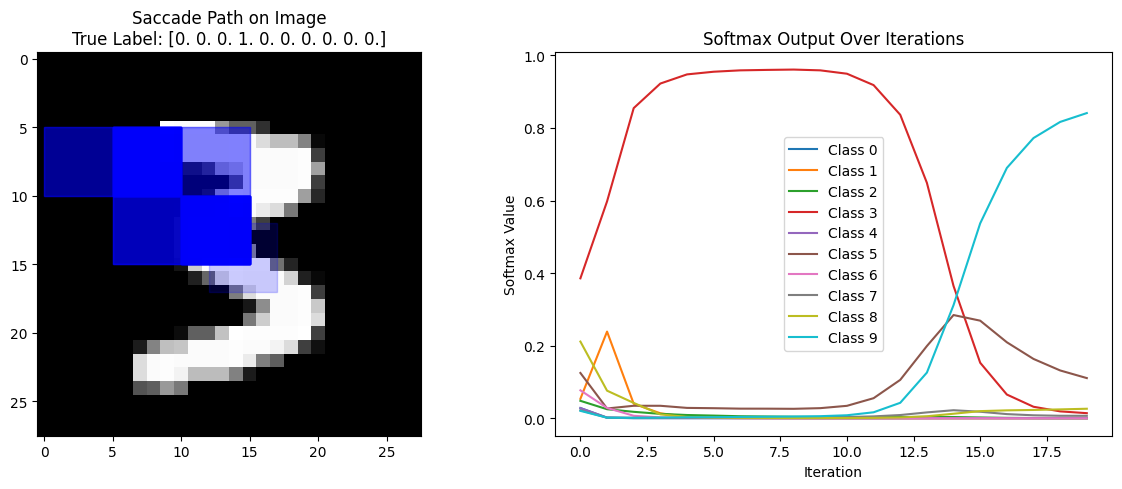

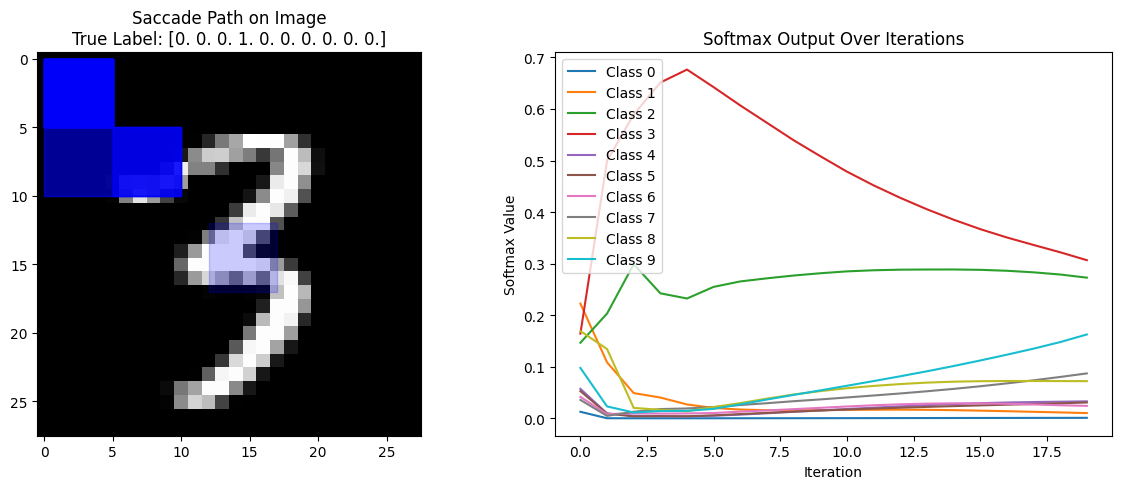

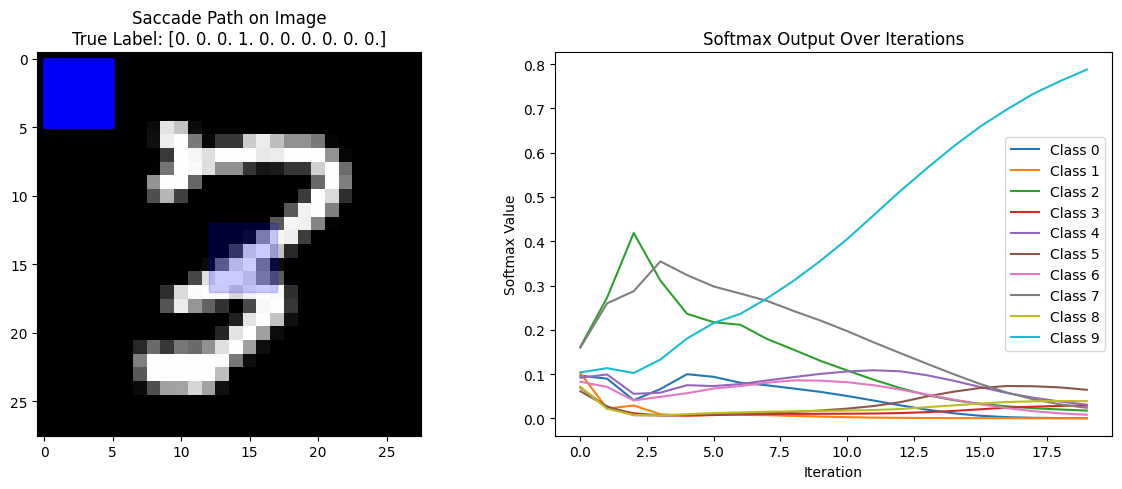

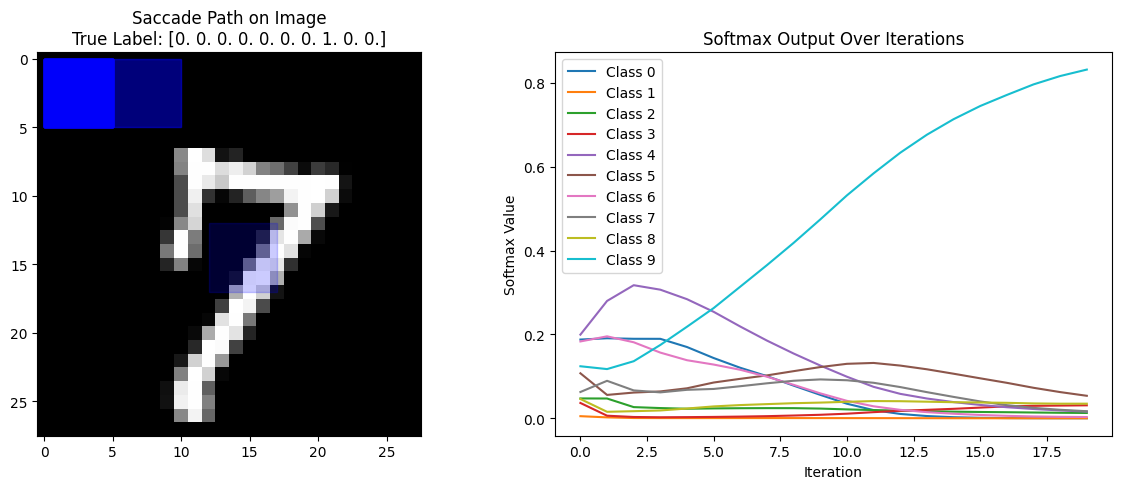

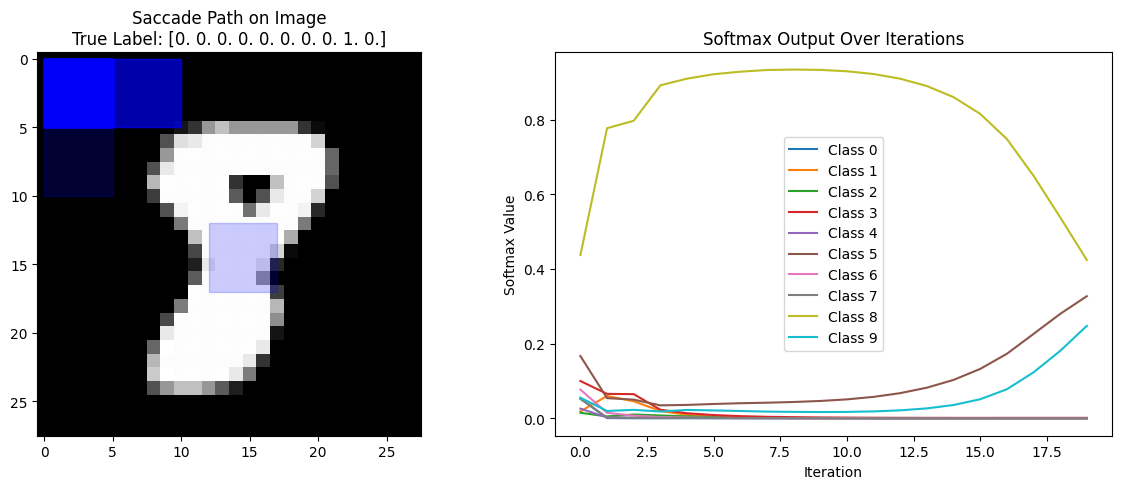

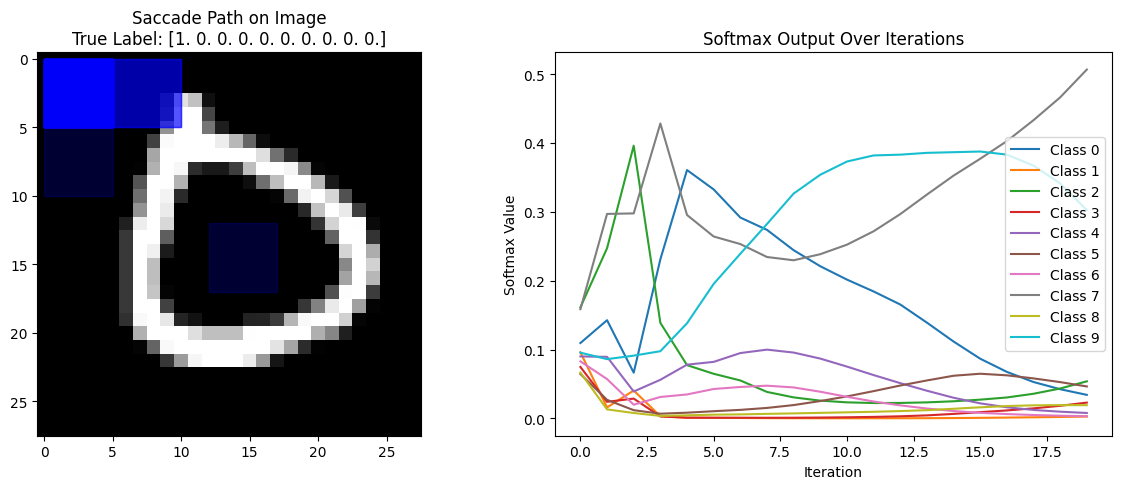

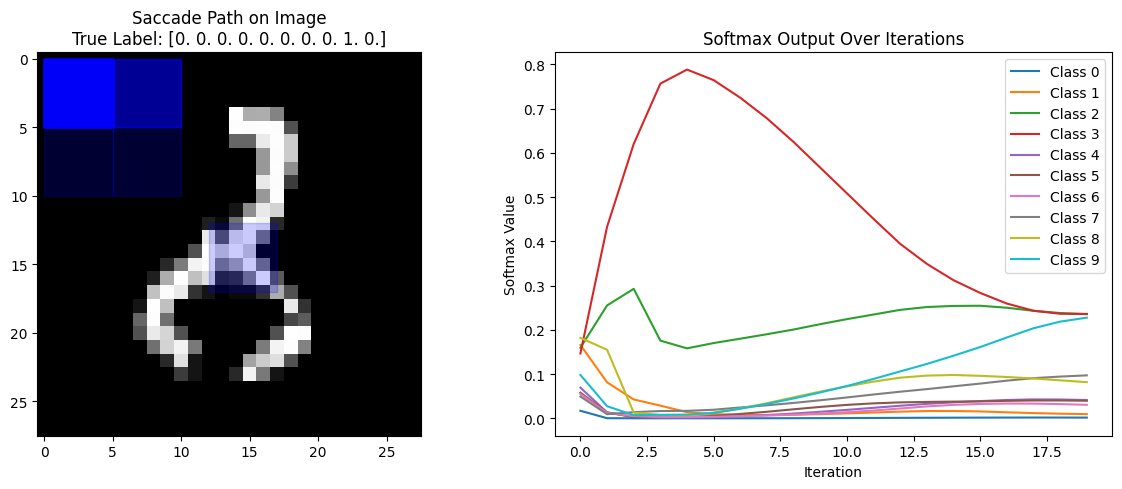

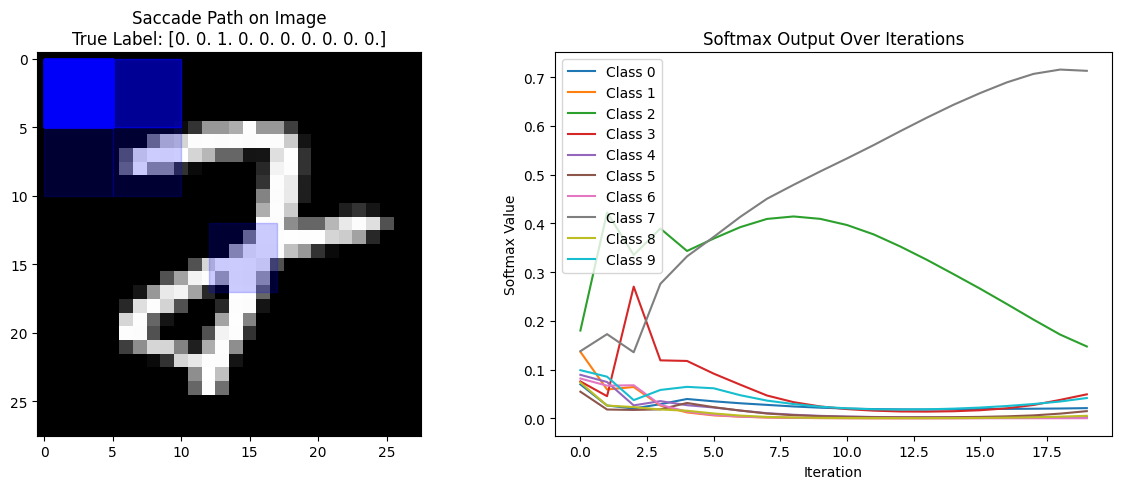

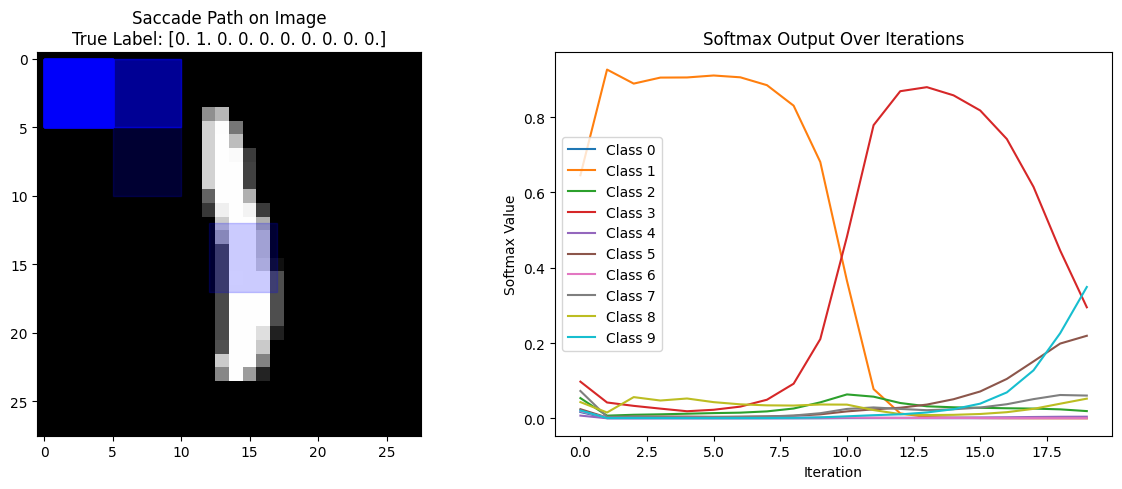

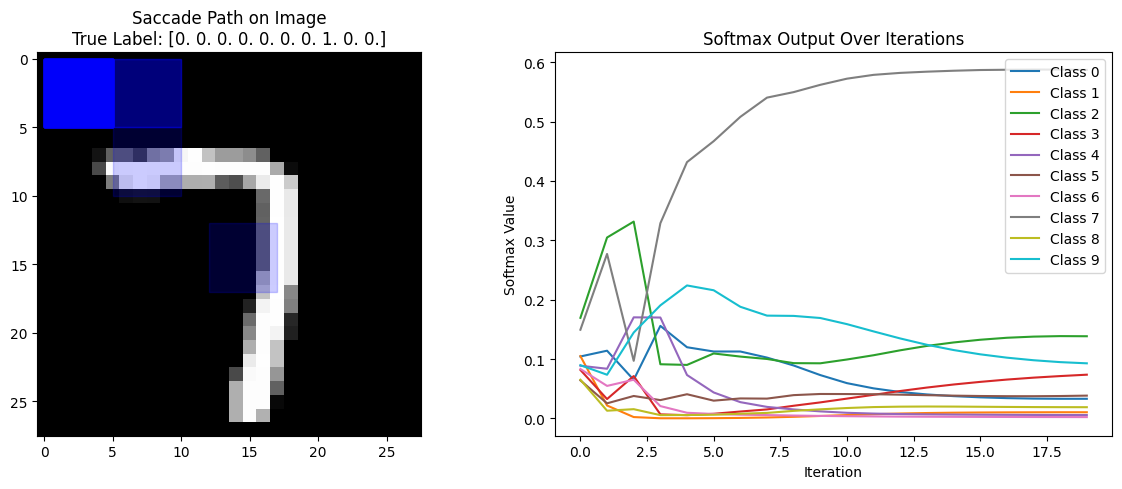

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

def inspect_model(model, train_data, num_steps=None, num_plots=1):
    # If num_steps is not provided, use model's max_iterations
    if num_steps is None:
        num_steps = model.max_iterations
    else:
        model.max_iterations = num_steps

    # Randomly select an image from the training data
    img, label = next(iter(train_data.shuffle(1000).take(1)))
    img = np.squeeze(img.numpy())

    # Reshape img to ensure it has 4 dimensions
    img_reshaped = tf.reshape(img, (-1, 28, 28, 1))

    # Get the model predictions
    softmax_preds, _, saccade_coords,_ = model(img_reshaped, False)
    #saccade_positions = model.coordinates_to_patch_index(saccade_coords[:, :, 0], saccade_coords[:, :, 1], 28)
    saccade_positions = saccade_coords
    for plot_idx in range(num_plots):
        # Calculate the top-left corner of the selected patch
        patch_centers = [(i // (28 // model.patch_size) * model.patch_size,
                          i % (28 // model.patch_size) * model.patch_size)
                         for i in saccade_positions[plot_idx].numpy()]

        # Add the starting patch (center) as the first coordinates
        center_patch = (28 // 2 - model.patch_size // 2, 28 // 2 - model.patch_size // 2)
        patch_centers.insert(0, center_patch)

        # Plotting
        plt.figure(figsize=(12, 5))

        # Left plot: Image with saccade path
        plt.subplot(1, 2, 1)
        plt.imshow(np.squeeze(img_reshaped[plot_idx]), cmap='gray')

        # Draw saccade path with translucent shaded box
        for (cy, cx) in patch_centers:
            rect = patches.Rectangle((cx, cy), model.patch_size, model.patch_size,
                                     linewidth=1, edgecolor='blue', facecolor='blue', alpha=0.2)
            plt.gca().add_patch(rect)

        plt.title(f"Saccade Path on Image\nTrue Label: {label.numpy()[plot_idx]}")

        # Right plot: Softmax outputs
        plt.subplot(1, 2, 2)
        for i in range(10):
            plt.plot(softmax_preds[plot_idx, :, i], label=f"Class {i}")

        plt.title("Softmax Output Over Iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Softmax Value")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Inspect the model for a specific number of steps
inspect_model(trained_predictive_model, val_dataset, num_steps=20, num_plots=10)


(20,)


<ipython-input-14-3fb78177f241>:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b:" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x, y, 'b:', color='blue', marker=(3, 0, np.degrees(np.arctan2(np.diff(y), np.diff(x))[0])))  # Blue dotted line with arrow


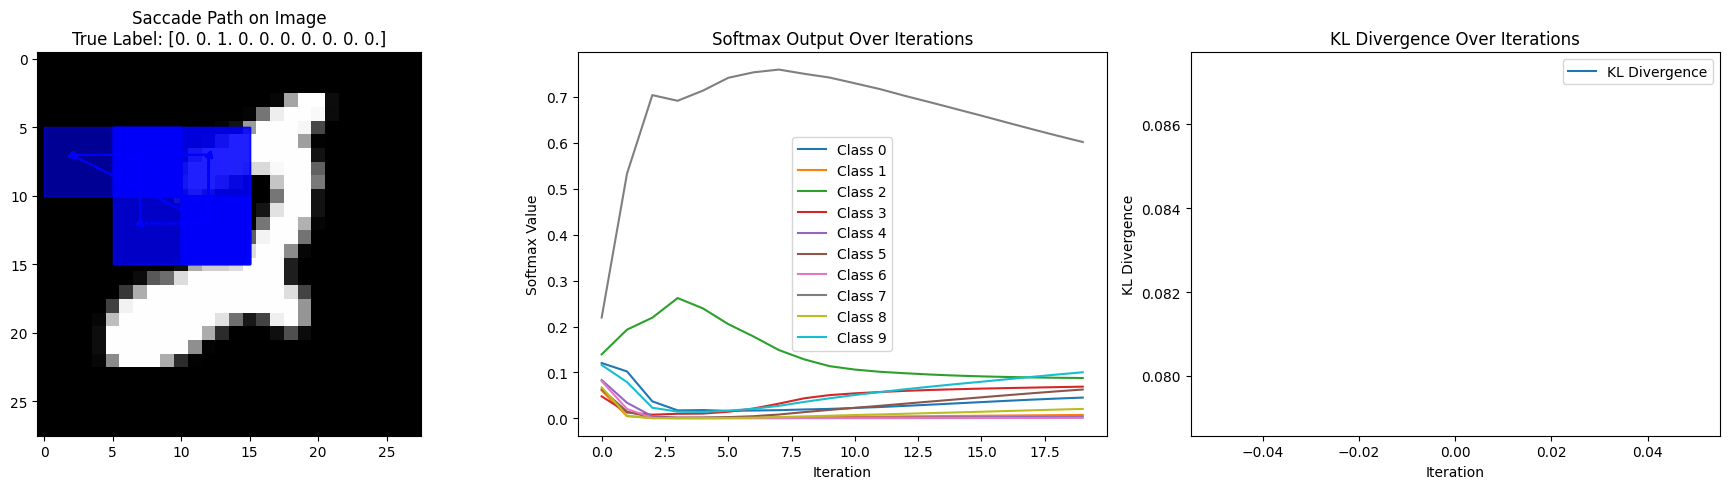

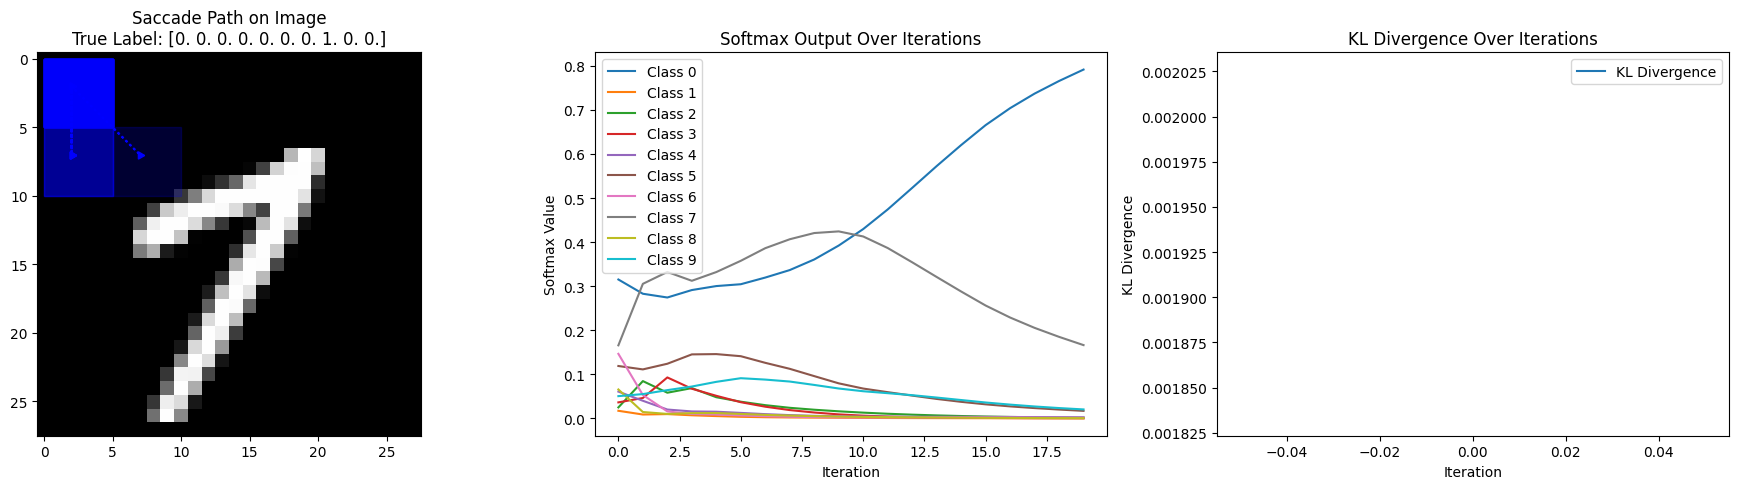

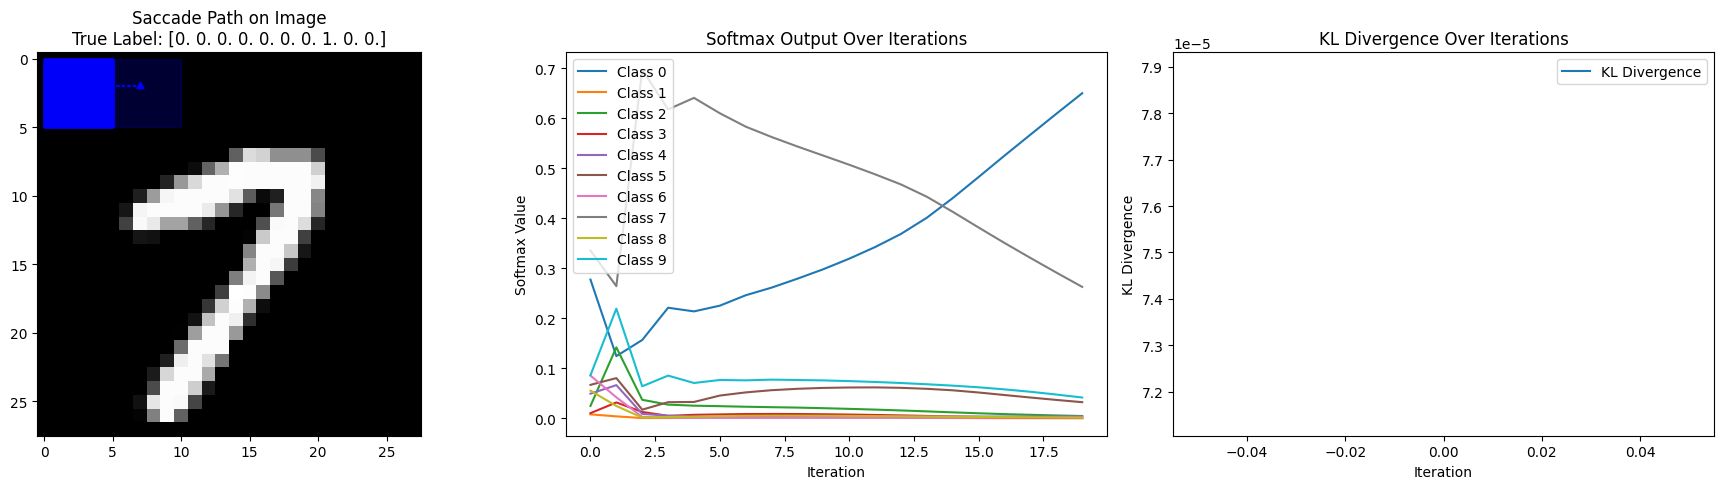

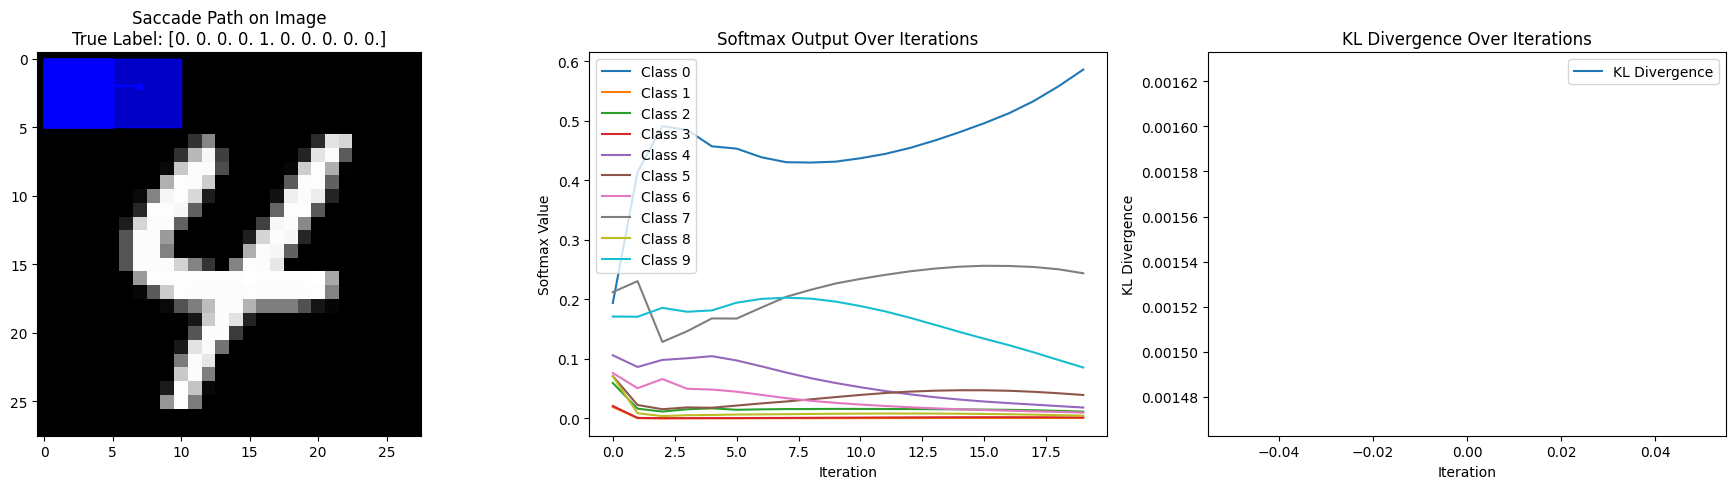

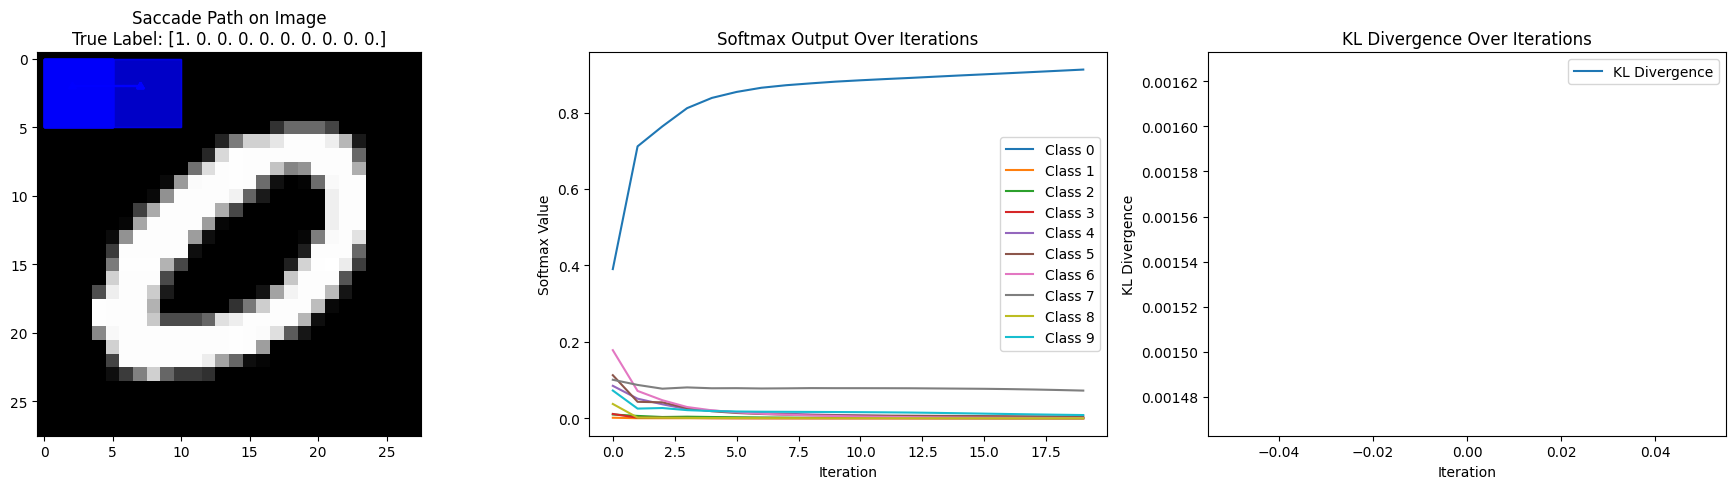

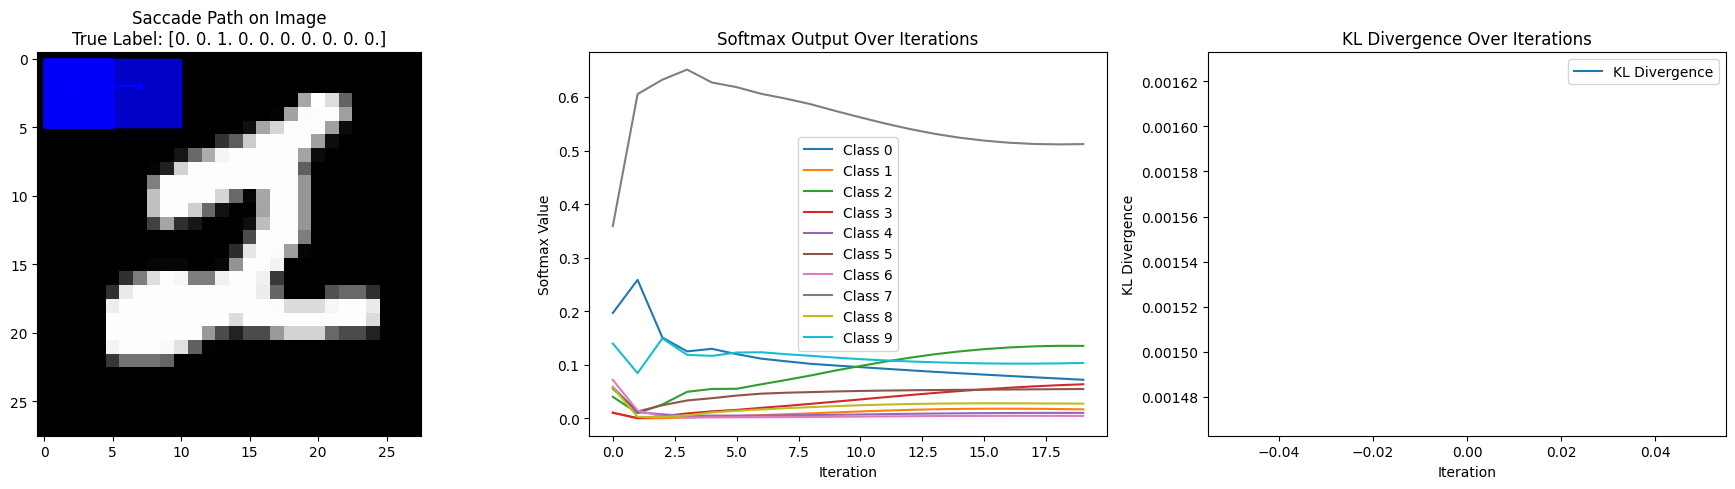

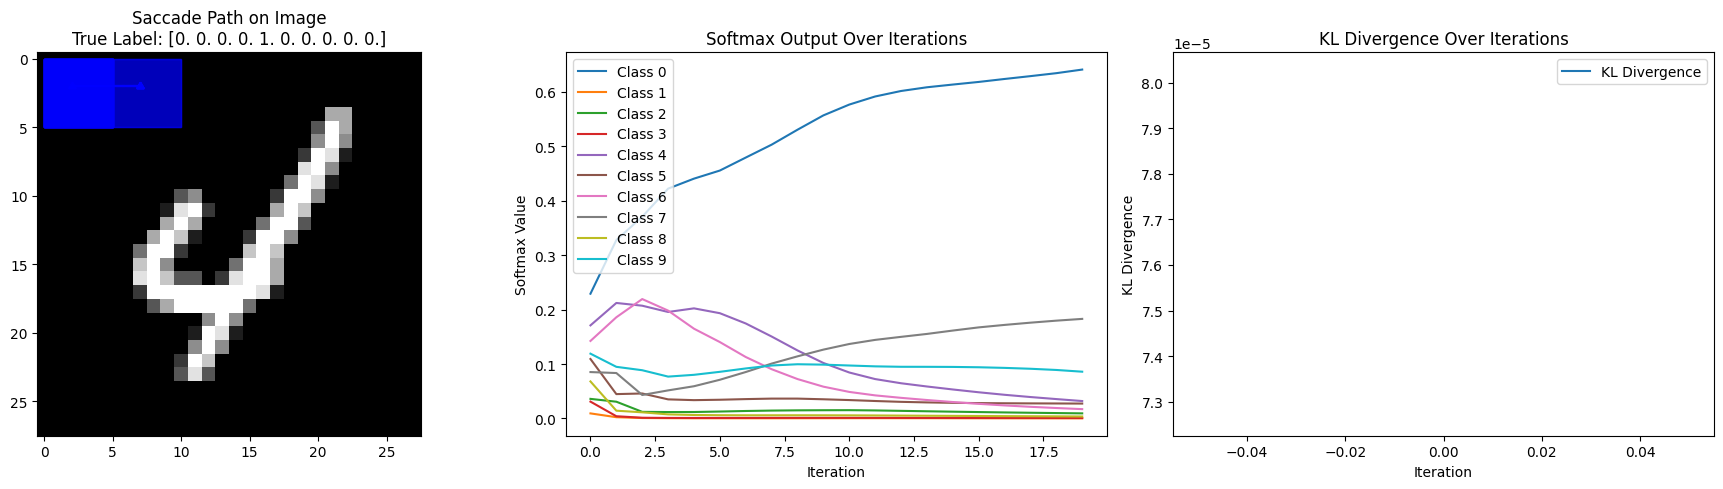

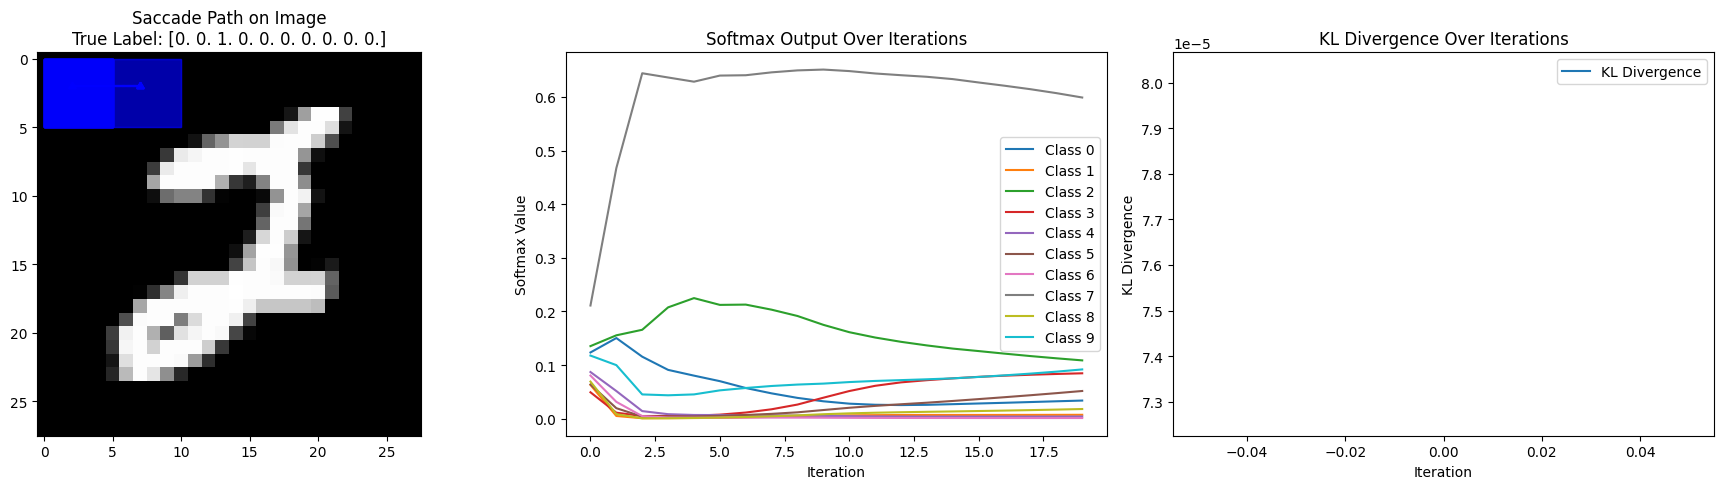

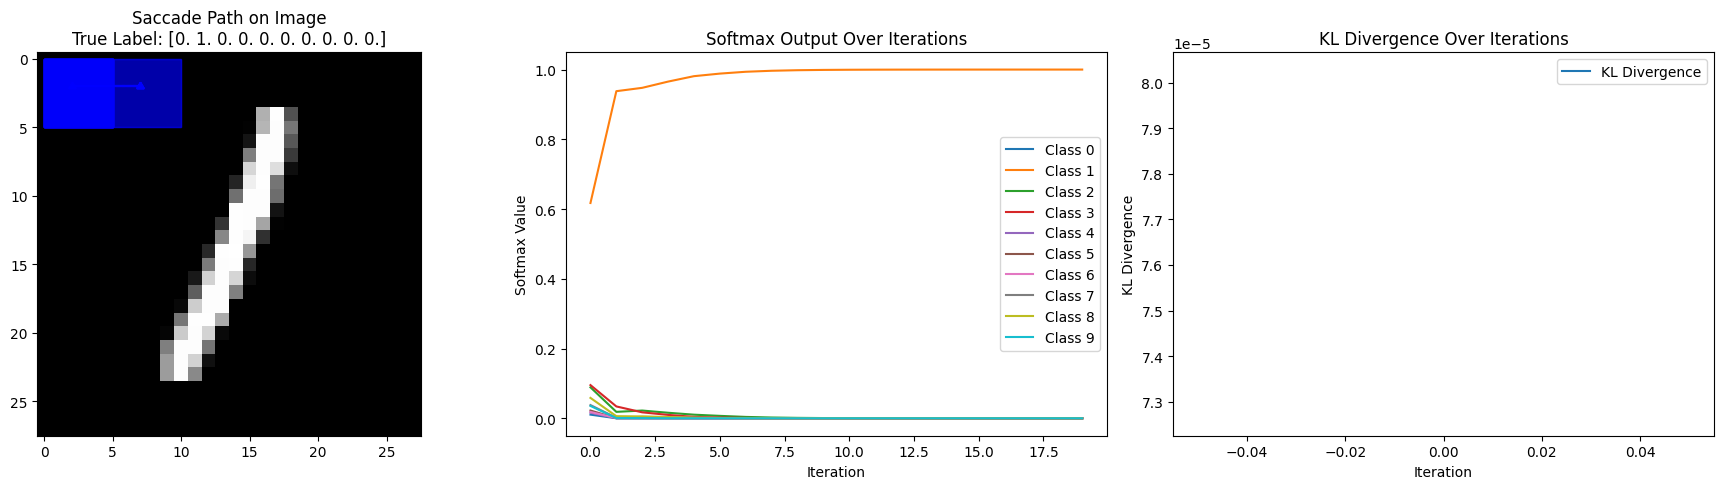

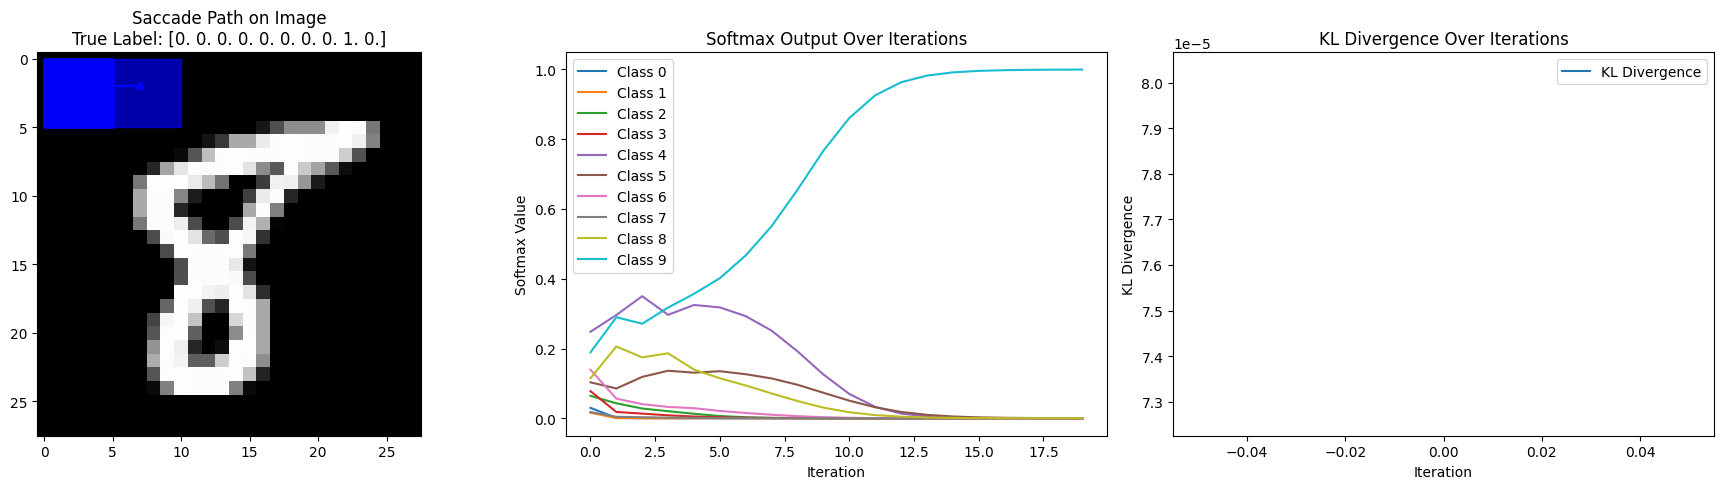

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow.keras.losses import KLDivergence

def inspect_model(model, train_data, num_steps=None, num_plots=1):
    # If num_steps is not provided, use model's max_iterations
    if num_steps is None:
        num_steps = model.max_iterations
    else:
        model.max_iterations = num_steps

    # Randomly select an image from the training data
    img, label = next(iter(train_data.shuffle(1000).take(1)))
    img = np.squeeze(img.numpy())

    # Reshape img to ensure it has 4 dimensions
    img_reshaped = tf.reshape(img, (-1, 28, 28, 1))

    # Get the model predictions
    softmax_preds,kl_divergences,saccade_coords,_ = model(img_reshaped,False)
    print(kl_divergences.shape)
    #saccade_positions = model.coordinates_to_patch_index(saccade_coords[:,:, 0], saccade_coords[:,:, 1], 28)
    saccade_positions = saccade_coords
    for plot_idx in range(num_plots):
        # Calculate the center of the selected patch
        patch_centers = [(i // (28 // model.patch_size) * model.patch_size + model.patch_size // 2,
                        i % (28 // model.patch_size) * model.patch_size + model.patch_size // 2)
                        for i in saccade_positions[plot_idx].numpy()]
        #patch_centers = [(int(coords[0] * 28), int(coords[1] * 28)) for coords in saccade_coords[plot_idx]]

        #break
        # Plotting
        plt.figure(figsize=(18, 5))

        # Left plot: Image with saccade path
        plt.subplot(1, 3, 1)
        plt.imshow(np.squeeze(img_reshaped[plot_idx]), cmap='gray')

        # Draw saccade path with translucent shaded box and arrow
        if patch_centers:
            y, x = zip(*patch_centers)
            plt.plot(x, y, 'b:', color='blue', marker=(3, 0, np.degrees(np.arctan2(np.diff(y), np.diff(x))[0])))  # Blue dotted line with arrow
            for (cy, cx) in patch_centers:
                rect = patches.Rectangle((cx - model.patch_size // 2, cy - model.patch_size // 2), model.patch_size, model.patch_size,
                                         linewidth=1, edgecolor='blue', facecolor='blue', alpha=0.2)
                plt.gca().add_patch(rect)

        plt.title(f"Saccade Path on Image\nTrue Label: {label.numpy()[plot_idx]}")

        # Middle plot: Softmax outputs
        plt.subplot(1, 3, 2)
        for i in range(10):
            plt.plot(softmax_preds[plot_idx, :, i], label=f"Class {i}")

        plt.title("Softmax Output Over Iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Softmax Value")
        plt.legend()

        # Right plot: KL Divergence over iterations
        plt.subplot(1, 3, 3)
        plt.plot(kl_divergences[plot_idx], label="KL Divergence")
        plt.title("KL Divergence Over Iterations")
        plt.xlabel("Iteration")
        plt.ylabel("KL Divergence")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Inspect the model for a specific number of steps
inspect_model(trained_predictive_model, val_dataset, num_steps=20, num_plots=10)


In [ ]:
import tensorflow as tf

class RecursiveAttentionModelC(tf.keras.Model):
    def __init__(self, patch_size, num_hidden, max_iterations=50, temperature=1.0, time_weight=1.0, **kwargs):
        super(RecursiveAttentionModelC, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.num_hidden = num_hidden
        self.num_patches = (28 // patch_size) * (28 // patch_size)
        self.max_iterations = max_iterations
        self.temperature = temperature
        self.time_weight = time_weight
        # self.W = self.add_weight(shape=(self.patch_size**2 + num_hidden + self.num_patches + 10,
        #                                 self.patch_size**2 + num_hidden + self.num_patches + 10),
        #                          initializer='random_normal',regularizer=tf.keras.regularizers.L1(0.01),
        #                          trainable=True)
        # self.b = self.add_weight(shape=(self.patch_size**2 + num_hidden + self.num_patches + 10,),
        #                          initializer='zeros',
        #                          trainable=True)
        self.activity_regularizer = tf.keras.layers.ActivityRegularization(l1=0.1,l2=0.01)
        self.dense1 = tf.keras.layers.Dense(self.num_hidden,activation='relu')
        self.dense2 = tf.keras.layers.Dense(self.num_hidden,activation='relu')

        self.dense3 = tf.keras.layers.Dense(self.num_hidden,activation='relu')
        self.context = tf.keras.layers.Dense(self.num_hidden,activation='sigmoid')

        self.conv1 = tf.keras.layers.Conv2D(50,(2,2),activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64,(3,3),strides=(2,2),activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(1,(1,1),activation='relu')

        self.y_softmax = tf.keras.layers.Dense(10,activation = 'softmax')
        self.s_coord = tf.keras.layers.Dense(2,activation = 'sigmoid')

        #self.mp = tf.keras.layers.MaxPool2D((2,2))
        self.concat = tf.keras.layers.Concatenate()
        self.flatten = tf.keras.layers.Flatten()

        self.decode1 = tf.keras.layers.Dense(7*7*3,activation='relu')
        self.reshape = tf.keras.layers.Reshape((7,7,3))
        self.deconv1 = tf.keras.layers.Conv2DTranspose(64,(3,3),activation='relu',padding='same')
        self.sample1 = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')
        self.deconv2 = tf.keras.layers.Conv2DTranspose(32,(3,3),activation='relu',padding='same')
        self.sample2 = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')
        self.deconv3 = tf.keras.layers.Conv2DTranspose(1,(3,3),activation='relu',padding='same')
        self.out = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid',padding='same')

    def call(self, inputs):

        initial_position = tf.ones((tf.shape(inputs)[0], 2))/2
        s_coords = initial_position
        C = tf.zeros((tf.shape(inputs)[0],self.num_hidden+12))

        predictions = []
        Saccades = []
        decodes=[]
        for t in range(self.max_iterations):
            glimpse = tf.image.extract_glimpse(
                            inputs,
                            size=(self.patch_size,self.patch_size),
                            offsets=s_coords,
                            centered=False,
                            normalized=True,
                        )

            glimpse = tf.stop_gradient(glimpse)
            x = self.conv1(glimpse)

            #x = self.mp(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.flatten(x)

            H1=self.dense1(x)
            H1 = self.concat([H1,C])
            H2 = self.dense2(H1)
            H2 = self.activity_regularizer(H2)
            H3 = self.dense3(H2)

            C = self.context(H3)
            Y = self.y_softmax(H3)
            s_coords = self.s_coord(H3)
            C = self.concat([s_coords,Y,C])
            d = self.decode1(H3)

            d = self.reshape(d)
            d = self.deconv1(d)

            d = self.sample1(d)
            d = self.deconv2(d)

            d = self.sample2(d)
            d = self.deconv3(d)
            decode = self.out(d)
            # Append the prediction without weighting

            predictions.append(Y)
            Saccades.append(s_coords)
            decodes.append(decode)
        return tf.stack(predictions, axis=1),tf.stack(Saccades,axis=1), tf.stack(decodes,axis=1)

def train_recursive_attention_model(model, train_dataset, val_dataset, optimizer, EPOCHS=5):
    # Define loss
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    decode_loss = tf.keras.losses.MeanSquaredError()
    train_loss_per_step = []
    train_accuracy_per_step = []
    val_loss_results = []
    val_accuracy_results = []

    for epoch in range(EPOCHS):
        batch_accuracy = tf.keras.metrics.CategoricalAccuracy()

        # Training loop
        for x_batch, y_batch in train_dataset:
            with tf.GradientTape() as tape:
                predictions,_,decodes = model(x_batch)

                y_batch_tiled = tf.tile(y_batch[:, tf.newaxis, :], [1, model.max_iterations, 1])
                x_batch_tiled = tf.tile(x_batch[:, tf.newaxis,:, :,:], [1, model.max_iterations,1,1, 1])

                step_losses = loss_fn(y_batch_tiled, predictions)
                step_weights = tf.range(1, model.max_iterations + 1, dtype=tf.float32) / model.max_iterations

                decode_losses = decode_loss(x_batch_tiled,decodes)
                decay_rate = 0.1  # You can adjust this parameter
                step_weights = tf.exp(-decay_rate * tf.range(0, model.max_iterations, dtype=tf.float32))

                weighted_loss = tf.reduce_sum(step_weights * step_losses)
                weighted_p_loss = tf.reduce_sum(step_weights * decode_losses)

                loss_value = tf.reduce_mean(weighted_loss) + tf.reduce_mean(weighted_p_loss)

            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Record loss and accuracy per step
            train_loss_per_step.append(loss_value.numpy())
            batch_accuracy(y_batch, predictions[:, -1, :])
            train_accuracy_per_step.append(batch_accuracy.result().numpy())

        # Validation loop
        val_loss_avg = tf.keras.metrics.Mean()
        val_accuracy = tf.keras.metrics.CategoricalAccuracy()
        for x_val, y_val in val_dataset:
            val_predictions,_,_ = model(x_val)
            y_val_tiled = tf.tile(y_val[:, tf.newaxis, :], [1, model.max_iterations, 1])
            val_step_losses = loss_fn(y_val_tiled, val_predictions)
            val_weighted_loss = tf.reduce_sum(step_weights * val_step_losses)
            val_loss_value = tf.reduce_mean(val_weighted_loss)

            val_loss_avg(val_loss_value)
            val_accuracy(y_val, val_predictions[:, -1, :])

        # Calculating epoch-wise metrics
        val_loss_results.append(val_loss_avg.result())
        val_accuracy_results.append(val_accuracy.result())

        print(f"Epoch {epoch+1}: "
              f"Train Loss: {train_loss_per_step[-1]:.4f}, "
              f"Train Accuracy: {train_accuracy_per_step[-1]:.4f}, "
              f"Val Loss: {val_loss_results[-1]:.4f}, "
              f"Val Accuracy: {val_accuracy_results[-1]:.4f}")

    # Plotting the learning curves
    plt.figure(figsize=(12, 5))

    # Plot for Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_per_step, label='Train Loss')
    plt.title('Train Loss per step')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_per_step, label='Train Accuracy')
    plt.title('Train Accuracy per step')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
# Load the MNIST dataset
(x_train, y_train), (x_val, y_val) = mnist.load_data()

# Normalize and reshape the data
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

x_train_reshaped = x_train.reshape((-1, 28, 28, 1))
x_val_reshaped = x_val.reshape((-1, 28, 28, 1))

# Convert labels to one-hot encoded format
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

# Create tf.data.Dataset for both training and validation
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_reshaped, y_train)).batch(BATCH_SIZE).shuffle(buffer_size=10000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_reshaped, y_val)).batch(BATCH_SIZE)


In [ ]:

def train_model_with_subsample(subsample_size=None):
    # Subsample the training data if subsample_size is specified
    if subsample_size is not None:
        train_dataset_subsampled = train_dataset.take(subsample_size // BATCH_SIZE)
    else:
        train_dataset_subsampled = train_dataset

    # Initialize the optimizer and model
    optimizer = tf.keras.optimizers.Adam(0.02)
    model = RecursiveAttentionModelC(patch_size=9, num_hidden=100, max_iterations=10, temperature=1)

    # Train the model
    train_recursive_attention_model(model, train_dataset_subsampled, val_dataset, optimizer, EPOCHS=10)

    # Return the trained model for further inspection
    return model

# Example usage with subsample size
trained_model = train_model_with_subsample(subsample_size=10000)

# Now you can inspect `trained_model` as needed


Epoch 1: Train Loss: 15.9531, Train Accuracy: 0.1024, Val Loss: 15.2874, Val Accuracy: 0.1135
Epoch 2: Train Loss: 15.9930, Train Accuracy: 0.1110, Val Loss: 15.2933, Val Accuracy: 0.1135
Epoch 3: Train Loss: 16.0075, Train Accuracy: 0.1063, Val Loss: 15.2910, Val Accuracy: 0.1135
Epoch 4: Train Loss: 16.1680, Train Accuracy: 0.1082, Val Loss: 15.2856, Val Accuracy: 0.1135
Epoch 5: Train Loss: 16.1562, Train Accuracy: 0.1050, Val Loss: 15.2867, Val Accuracy: 0.1135


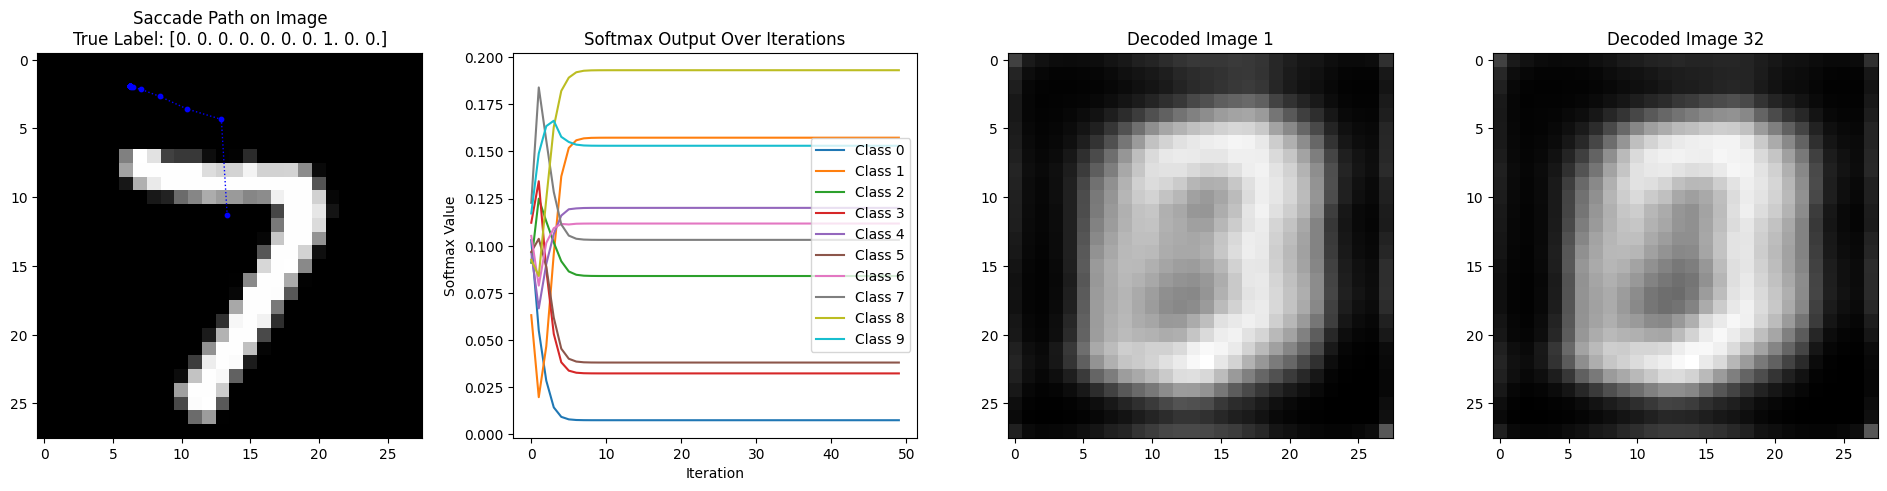

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def inspect_model(model, train_data, num_steps=None, num_plots=1):
    # If num_steps is not provided, use model's max_iterations
    if num_steps is None:
        num_steps = model.max_iterations
    else:
        model.max_iterations = num_steps

    # Randomly select an image from the training data
    img, label = next(iter(train_data.shuffle(1000).take(1)))
    img = np.squeeze(img.numpy())

    # Reshape img to ensure it has 4 dimensions
    img_reshaped = tf.reshape(img, (-1, 28, 28, 1))

    # Get the model predictions
    predictions,  saccades, decoded = model(img_reshaped)

    # Extract saccade positions from normalized coordinates
    s_coords = saccades.numpy()  # Assuming saccades are in normalized coordinates

      # Convert to image coordinates

    for plot_idx in range(num_plots):
        plt.figure(figsize=(24, 5))
        saccade_positions = [((y * 27), (x * 27)) for y, x in s_coords[plot_idx]]
        # Plot the original image with saccade path
        plt.subplot(1, 4, 1)
        plt.imshow(img[plot_idx], cmap='gray')
        if saccade_positions:
            y, x = zip(*saccade_positions)
            plt.scatter(x, y, c='blue', s=10)  # Plot each saccade position
            plt.plot(x, y, 'b:', lw=1)  # Connect saccade positions with a blue dotted line

        plt.title(f"Saccade Path on Image\nTrue Label: {label.numpy()[plot_idx]}")

        # Plot softmax outputs
        plt.subplot(1, 4, 2)
        softmax_vals = predictions.numpy()
        for i in range(10):
            plt.plot(softmax_vals[plot_idx, :, i], label=f"Class {i}")

        plt.title("Softmax Output Over Iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Softmax Value")
        plt.legend()

        # Plot each 28x28 image from decoded
        for i, dec_img in enumerate(decoded.numpy()):
            if i <= 1:
              plt.subplot(1, 4, 3+i)
            else: plt.subplot(1, 4,4)
            plt.imshow(dec_img[plot_idx].reshape(28, 28), cmap='gray')
            plt.title(f"Decoded Image {i+1}")

        plt.show()

# Inspect the model for a specific number of steps
inspect_model(trained_model, val_dataset, num_steps=50, num_plots=1)


-